In [47]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import geopy.distance
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
## upload the 1000000 trip records randomly selected from each of the big dataset
taxi_green_df = pd.read_csv("summary/nyc_taxi_green_2015_combine_1000000.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
taxi_yellow_df = pd.read_csv("summary/nyc_taxi_yellow_2015_combine_1000000.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])

In [3]:
print('Number of columns for green taxi tripdata: {}'.format(taxi_green_df.shape[1]))
print('Number of rows for green taxi tripdata: {}'.format(taxi_green_df.shape[0]))
print('Columns for green taxi tripdata: {}'.format(taxi_green_df.columns.values))
print('\n')
print('Number of columns for yellow taxi tripdata: {}'.format(taxi_yellow_df.shape[1]))
print('Number of rows for yellow taxi tripdata: {}'.format(taxi_yellow_df.shape[0]))
print('Columns for yellow taxi tripdata: {}'.format(taxi_yellow_df.columns.values))

Number of columns for green taxi tripdata: 22
Number of rows for green taxi tripdata: 1000000
Columns for green taxi tripdata: ['VendorID' 'pickup_datetime' 'dropoff_datetime' 'Store_and_fwd_flag'
 'RateCodeID' 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'passenger_count' 'trip_distance' 'fare_amount'
 'Extra' 'MTA_tax' 'Tip_amount' 'Tolls_amount' 'Ehail_fee'
 'improvement_surcharge' 'total_amount' 'Payment_type' 'Trip_type '
 'trip_ID']


Number of columns for yellow taxi tripdata: 21
Number of rows for yellow taxi tripdata: 1000000
Columns for yellow taxi tripdata: ['RateCodeID' 'RatecodeID' 'VendorID' 'dropoff_latitude'
 'dropoff_longitude' 'extra' 'fare_amount' 'improvement_surcharge'
 'mta_tax' 'passenger_count' 'payment_type' 'pickup_latitude'
 'pickup_longitude' 'store_and_fwd_flag' 'tip_amount' 'tolls_amount'
 'total_amount' 'dropoff_datetime' 'pickup_datetime' 'trip_distance'
 'trip_ID']


# 1. Data cleaning and pre-processing

## 1.1 Drop NA (missing) values

In [5]:
taxi_green_df.isna().sum()

VendorID                       0
pickup_datetime                0
dropoff_datetime               0
Store_and_fwd_flag             0
RateCodeID                     0
pickup_longitude               0
pickup_latitude                0
dropoff_longitude              0
dropoff_latitude               0
passenger_count                0
trip_distance                  0
fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1000000
improvement_surcharge          0
total_amount                   0
Payment_type                   0
Trip_type                      0
trip_ID                        0
dtype: int64

In [6]:
taxi_yellow_df.isna().sum()

RateCodeID               473205
RatecodeID               526795
VendorID                      0
dropoff_latitude              0
dropoff_longitude             0
extra                         0
fare_amount                   0
improvement_surcharge         0
mta_tax                       0
passenger_count               0
payment_type                  0
pickup_latitude               0
pickup_longitude              0
store_and_fwd_flag            0
tip_amount                    0
tolls_amount                  0
total_amount                  0
dropoff_datetime              0
pickup_datetime               0
trip_distance                 0
trip_ID                       0
dtype: int64

`Ehail_fee` only contains NA values in green taxi dataset and we can drop this column.

NA values for `RateCodeID` and `RatecodeID` adds up to 1000000, and by quickly checking the data, I noticed that the data in these two columns complement each other and can thus be combined.

In [4]:
taxi_green_df = taxi_green_df.drop(['Ehail_fee'], axis = 1)

In [5]:
taxi_yellow_df['ratecodeID'] = [taxi_yellow_df.iloc[i,0] if np.isnan(taxi_yellow_df.iloc[i,0]) == False else taxi_yellow_df.iloc[i,1] for i in np.arange(0,taxi_yellow_df.shape[0])]
taxi_yellow_df['ratecodeID'].isna().sum()
taxi_yellow_df = taxi_yellow_df.drop(['RateCodeID', 'RatecodeID'], axis = 1)

## 1.2 Compute and extract datetime and geographical information

### 1.2.1 Extract datetime information

Get information of year, day of week, hour, month, day of year and trip duration for each trip from the `pickup_datetime` and `dropoff_datetime` columns

In [6]:
def datetime_info(df):
    df["year"] = df.pickup_datetime.apply(lambda x: x.year)
    df["weekday"] = df.pickup_datetime.apply(lambda x: x.weekday())
    df["hour"] = df.pickup_datetime.apply(lambda x: x.hour)
    df["month"] = df.pickup_datetime.apply(lambda x: x.month)
    df["day_of_year"] = df.pickup_datetime.apply(lambda x: x.timetuple().tm_yday)
    df["trip_duration_sec"] = (df.dropoff_datetime - df.pickup_datetime).astype('timedelta64[s]')
    return df

In [7]:
taxi_green_df = datetime_info(taxi_green_df)
taxi_yellow_df = datetime_info(taxi_yellow_df)

Some trips have `trip_duration_sec` equal 0. These may be trips canceled or due to other reasons, but should be removed from the dataset.

In [8]:
taxi_green_df = taxi_green_df[taxi_green_df.trip_duration_sec > 0]
taxi_yellow_df = taxi_yellow_df[taxi_yellow_df.trip_duration_sec > 0]
print('Number of data points for green taxi data after filtering: {}'.format(taxi_green_df.shape[0]))
print('Number of data points for yellow taxi data after filtering: {}'.format(taxi_yellow_df.shape[0]))

Number of data points for green taxi data after filtering: 999908
Number of data points for yellow taxi data after filtering: 999922


### 1.2.2 Compute trip distance and direction

Although `trip_distance` has been included in the dataset, it doesn't necessarily reflect the real geographical distance between pickup and dropoff locations. It would be helpful to compute and include an approximate geographical distance.  

In [40]:
def distance_func(x):
    return geopy.distance.distance((x.pickup_latitude, x.pickup_longitude), (x.dropoff_latitude, x.dropoff_longitude)).km

In [43]:
taxi_green_df['distance_cal'] = taxi_green_df.apply(distance_func, axis = 1)
taxi_yellow_df['distance_cal'] = taxi_yellow_df.apply(distance_func, axis = 1)

Here I also computed the overall direction of the trip as it may impact trip duration and real trip distance.

In [45]:
## function derived from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
def direction_func(df):
    df["delta_lon"] = df.dropoff_longitude-df.pickup_longitude
    df["delta_lat"] = df.dropoff_latitude-df.pickup_latitude
    result = np.zeros(len(df.delta_lon))
    l = np.sqrt(df.delta_lon**2 + df.delta_lat**2)
    result[df.delta_lon>0] = (180/np.pi)*np.arcsin(df.delta_lat[df.delta_lon>0]/l[df.delta_lon>0])
    idx = (df.delta_lon<0) & (df.delta_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(df.delta_lat[idx]/l[idx])
    idx = (df.delta_lon<0) & (df.delta_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(df.delta_lat[idx]/l[idx])
    return result

In [46]:
taxi_green_df['direction_cal'] = direction_func(taxi_green_df)
taxi_yellow_df['direction_cal'] = direction_func(taxi_yellow_df)

### 1.2.3 Compute speed

In [51]:
taxi_green_df['speed'] = taxi_green_df.trip_distance/taxi_green_df.trip_duration_sec * 3600.0
taxi_yellow_df['speed'] = taxi_yellow_df.trip_distance/taxi_yellow_df.trip_duration_sec * 3600.0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 1.3 Filtering geographical outliers

In [49]:
taxi_green_df['pickup_longitude'].describe()

count    999908.000000
mean        -73.877775
std           2.063715
min        -115.168869
25%         -73.959518
50%         -73.945244
75%         -73.917229
max           0.000000
Name: pickup_longitude, dtype: float64

In [50]:
taxi_green_df['pickup_latitude'].describe()

count    999908.000000
mean         40.717607
std           1.138404
min           0.000000
25%          40.699387
50%          40.746845
75%          40.803268
max          42.550228
Name: pickup_latitude, dtype: float64

As we can see from the summary statistics of the `pickup_longitude` and `pickup_latitude` that some geographical locations have outliers (the locations cannot be reached by NYC taxi) and need to be removed from the dataset.

Here I use a bounding box with geographical locations covering the NYC and surrounding area
`LL = (-74.30, -73.70, 40.56, 40.90)`. Only trips with both pickup and dropoff locations within the area defined by this bounding box will be used for the downstream analysis.

In [52]:
def boundingbox(df, LL):
    return (df.pickup_longitude >= LL[0]) & (df.pickup_longitude <= LL[1]) & (df.dropoff_longitude >= LL[0]) & (df.dropoff_longitude <= LL[1]) & (df.pickup_latitude >= LL[2]) & (df.pickup_latitude <= LL[3]) & (df.dropoff_latitude >= LL[2]) & (df.dropoff_latitude <= LL[3])

In [53]:
LL = (-74.30, -73.70, 40.56, 40.90)

In [54]:
taxi_green_df = taxi_green_df[boundingbox(taxi_green_df, LL)]
taxi_yellow_df = taxi_yellow_df[boundingbox(taxi_yellow_df, LL)]

In [55]:
print('Number of data points for green taxi data after filtering: {}'.format(taxi_green_df.shape[0]))
print('Number of data points for yellow taxi data after filtering: {}'.format(taxi_yellow_df.shape[0]))

Number of data points for green taxi data after filtering: 996380
Number of data points for yellow taxi data after filtering: 983697


In [9]:
# taxi_green_df.to_csv('summary/nyc_taxi_green_2015_combine_1000000_filter.csv', index = False)
# taxi_yellow_df.to_csv('summary/nyc_taxi_yellow_2015_combine_1000000_filter.csv', index = False)
taxi_green_df = pd.read_csv('summary/nyc_taxi_green_2015_combine_1000000_filter.csv')
taxi_yellow_df = pd.read_csv('summary/nyc_taxi_yellow_2015_combine_1000000_filter.csv')

In [10]:
print('Number of columns for green taxi tripdata: {}'.format(taxi_green_df.shape[1]))
print('Number of rows for green taxi tripdata: {}'.format(taxi_green_df.shape[0]))
print('Number of columns for yellow taxi tripdata: {}'.format(taxi_yellow_df.shape[1]))
print('Number of rows for yellow taxi tripdata: {}'.format(taxi_yellow_df.shape[0]))

Number of columns for green taxi tripdata: 32
Number of rows for green taxi tripdata: 996380
Number of columns for yellow taxi tripdata: 31
Number of rows for yellow taxi tripdata: 983697


In [58]:
taxi_green_df.head()

VendorID     pickup_datetime    dropoff_datetime Store_and_fwd_flag  \
0         2 2015-03-01 00:03:01 2015-03-01 00:35:21                  N   
1         2 2015-03-01 00:02:54 2015-03-01 00:07:39                  N   
2         2 2015-03-01 00:02:18 2015-03-01 00:04:25                  N   
3         2 2015-03-01 00:02:45 2015-03-01 00:48:39                  N   
4         2 2015-03-01 00:03:02 2015-03-01 00:06:34                  N   

   RateCodeID  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           1        -73.943108        40.808556         -74.005386   
1           1        -73.968300        40.679493         -73.979820   
2           1        -73.917953        40.770294         -73.923851   
3           1        -73.963264        40.675617         -73.947311   
4           1        -73.938461        40.846355         -73.932961   

   dropoff_latitude  passenger_count  ...  weekday  hour  month  day_of_year  \
0         40.719013                1  ...        6     0      3           60   
1         40.677349                1  ...        6     0      3           60   
2         40.774555                2  ...        6     0      3           60   
3         40.780369                1  ...        6     0      3           60   
4         40.847813                6  ...        6     0      3           60   

   trip_duration_sec  distance_cal  delta_lon  delta_lat  direction_cal  \
0             1940.0     11.248440  -0.062279  -0.089542    -124.819483   
1              285.0      1.002640  -0.011520  -0.002144    -169.458258   
2              127.0      0.686876  -0.005898   0.004261     144.151524   
3             2754.0     11.710334   0.015953   0.104752      81.340720   
4              212.0      0.491295   0.005501   0.001457      14.837401   

       speed  
0  20.319588  
1   9.978947  
2  12.188976  
3  13.607843  
4   8.490566  

[5 rows x 32 columns]

In [59]:
taxi_green_df.describe()

VendorID     RateCodeID  pickup_longitude  pickup_latitude  \
count  996380.000000  996380.000000     996380.000000    996380.000000   
mean        1.783358       1.065202        -73.935440        40.749198   
std         0.411957       0.496951          0.041780         0.057148   
min         1.000000       1.000000        -74.288193        40.572681   
25%         2.000000       1.000000        -73.959572        40.699425   
50%         2.000000       1.000000        -73.945320        40.746838   
75%         2.000000       1.000000        -73.917442        40.803150   
max         2.000000       6.000000        -73.701065        40.899948   

       dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
count      996380.000000     996380.000000    996380.000000  996380.000000   
mean          -73.934473         40.747004         1.376209       2.905067   
std             0.049709          0.057679         1.051127       2.944175   
min           -74.297783         40.560719         1.000000       0.010000   
25%           -73.967613         40.700180         1.000000       1.100000   
50%           -73.944756         40.747696         1.000000       1.940000   
75%           -73.910149         40.791519         1.000000       3.670000   
max           -73.700104         40.899986         9.000000     640.100000   

         fare_amount          Extra  ...        weekday           hour  \
count  996380.000000  996380.000000  ...  996380.000000  996380.000000   
mean       12.282155       0.357027  ...       3.274680      13.584496   
std         9.282953       0.364639  ...       1.960497       6.823931   
min         0.010000      -0.720000  ...       0.000000       0.000000   
25%         6.500000       0.000000  ...       2.000000       9.000000   
50%         9.500000       0.500000  ...       3.000000      15.000000   
75%        15.000000       0.500000  ...       5.000000      19.000000   
max       700.040000       2.000000  ...       6.000000      23.000000   

               month    day_of_year  trip_duration_sec   distance_cal  \
count  996380.000000  996380.000000      996380.000000  996380.000000   
mean        6.453310     180.742223        1014.323307       3.317621   
std         3.428534     104.695186        4267.807809       3.100650   
min         1.000000       1.000000           1.000000       0.000000   
25%         3.000000      90.000000         372.000000       1.302788   
50%         6.000000     176.000000         619.000000       2.311932   
75%         9.000000     272.000000        1022.000000       4.254366   
max        12.000000     365.000000      131362.000000      39.453412   

           delta_lon      delta_lat  direction_cal          speed  
count  996380.000000  996380.000000  996380.000000  996380.000000  
mean        0.000967      -0.002194      -7.582993      15.440666  
std         0.034810       0.031074     103.335785     144.711599  
min        -0.376587      -0.287384    -179.996981       0.000417  
25%        -0.014999      -0.014400    -106.802259       9.364922  
50%        -0.000160      -0.001034      -6.932542      11.732419  
75%         0.014427       0.011086      74.903243      14.888653  
max         0.395569       0.296772     179.996578   45720.000000  

[8 rows x 29 columns]

In [60]:
taxi_green_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996380 entries, 0 to 999999
Data columns (total 32 columns):
VendorID                 996380 non-null int64
pickup_datetime          996380 non-null datetime64[ns]
dropoff_datetime         996380 non-null datetime64[ns]
Store_and_fwd_flag       996380 non-null object
RateCodeID               996380 non-null int64
pickup_longitude         996380 non-null float64
pickup_latitude          996380 non-null float64
dropoff_longitude        996380 non-null float64
dropoff_latitude         996380 non-null float64
passenger_count          996380 non-null int64
trip_distance            996380 non-null float64
fare_amount              996380 non-null float64
Extra                    996380 non-null float64
MTA_tax                  996380 non-null float64
Tip_amount               996380 non-null float64
Tolls_amount             996380 non-null float64
improvement_surcharge    996380 non-null float64
total_amount             996380 non-null float64


In [61]:
taxi_yellow_df.head()

VendorID  dropoff_latitude  dropoff_longitude  extra  fare_amount  \
0         2         40.763321         -73.965408    0.0         12.5   
1         2         40.732590         -73.991249    0.0         15.5   
2         1         40.768909         -73.960632    0.0          5.0   
3         1         40.760311         -73.961327    0.5          4.5   
4         1         40.751019         -73.976059    0.0          5.5   

   improvement_surcharge  mta_tax  passenger_count  payment_type  \
0                    0.3      0.5                1             1   
1                    0.3      0.5                1             1   
2                    0.3      0.5                1             2   
3                    0.3      0.5                1             1   
4                    0.3      0.5                2             2   

   pickup_latitude  ...  weekday hour  month  day_of_year  trip_duration_sec  \
0        40.790646  ...        0   10      4           96              920.0   
1        40.764290  ...        3   12      4           99             1350.0   
2        40.766373  ...        0    7      6          159              290.0   
3        40.755707  ...        4    0      8          219              147.0   
4        40.759296  ...        3   11     11          309              309.0   

  distance_cal delta_lon  delta_lat  direction_cal      speed  
0     3.139708  0.009552  -0.027325     -70.731691  10.447826  
1     3.993033 -0.022316  -0.031700    -125.144439   7.546667  
2     0.757126 -0.008324   0.002537     163.050547   6.206897  
3     0.740306  0.006340   0.004604      35.988408  17.142857  
4     1.047647 -0.005951  -0.008278    -125.712132   8.155340  

[5 rows x 31 columns]

In [62]:
taxi_yellow_df.describe()

VendorID  dropoff_latitude  dropoff_longitude          extra  \
count  983697.000000     983697.000000      983697.000000  983697.000000   
mean        1.529546         40.751391         -73.973761       0.315261   
std         0.499127          0.031539           0.034716       0.362076   
min         1.000000         40.560238         -74.295807      -0.500000   
25%         1.000000         40.735550         -73.991447       0.000000   
50%         2.000000         40.754066         -73.980110       0.000000   
75%         2.000000         40.769024         -73.963615       0.500000   
max         2.000000         40.899994         -73.700378       7.000000   

         fare_amount  improvement_surcharge        mta_tax  passenger_count  \
count  983697.000000          983697.000000  983697.000000    983697.000000   
mean       12.807756               0.298569       0.498714         1.688695   
std        10.726257               0.020667       0.025320         1.341398   
min         0.010000               0.000000       0.000000         1.000000   
25%         6.500000               0.300000       0.500000         1.000000   
50%         9.500000               0.300000       0.500000         1.000000   
75%        14.500000               0.300000       0.500000         2.000000   
max      3002.000000               0.300000       0.500000         6.000000   

        payment_type  pickup_latitude  ...        weekday           hour  \
count  983697.000000    983697.000000  ...  983697.000000  983697.000000   
mean        1.375381        40.750701  ...       3.058954      13.551690   
std         0.494979         0.027700  ...       1.958011       6.464637   
min         1.000000        40.568420  ...       0.000000       0.000000   
25%         1.000000        40.737026  ...       1.000000       9.000000   
50%         1.000000        40.753658  ...       3.000000      14.000000   
75%         2.000000        40.767944  ...       5.000000      19.000000   
max         4.000000        40.899837  ...       6.000000      23.000000   

               month    day_of_year  trip_duration_sec   distance_cal  \
count  983697.000000  983697.000000       9.836970e+05  983697.000000   
mean        6.346626     177.464459       9.338890e+02       3.450587   
std         3.445512     105.095582       2.006280e+04       3.849259   
min         1.000000       1.000000       1.000000e+00       0.000000   
25%         3.000000      86.000000       4.020000e+02       1.259497   
50%         6.000000     172.000000       6.660000e+02       2.139687   
75%         9.000000     270.000000       1.078000e+03       3.943681   
max        12.000000     365.000000       1.974269e+07      44.720360   

           delta_lon      delta_lat  direction_cal         speed  
count  983697.000000  983697.000000  983697.000000  9.836970e+05  
mean        0.000187       0.000690     -13.141377  4.880033e+02  
std         0.044253       0.032140      99.690239  4.336085e+05  
min        -0.504799      -0.282871    -179.994750  1.641114e-04  
25%        -0.011497      -0.013832    -114.263074  7.751938e+00  
50%         0.001358       0.000198       1.479288  1.058824e+01  
75%         0.014137       0.014225      60.732600  1.442289e+01  
max         0.387970       0.256897     179.996536  4.294688e+08  

[8 rows x 28 columns]

In [63]:
taxi_yellow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983697 entries, 0 to 999999
Data columns (total 31 columns):
VendorID                 983697 non-null int64
dropoff_latitude         983697 non-null float64
dropoff_longitude        983697 non-null float64
extra                    983697 non-null float64
fare_amount              983697 non-null float64
improvement_surcharge    983697 non-null float64
mta_tax                  983697 non-null float64
passenger_count          983697 non-null int64
payment_type             983697 non-null int64
pickup_latitude          983697 non-null float64
pickup_longitude         983697 non-null float64
store_and_fwd_flag       983697 non-null object
tip_amount               983697 non-null float64
tolls_amount             983697 non-null float64
total_amount             983697 non-null float64
dropoff_datetime         983697 non-null datetime64[ns]
pickup_datetime          983697 non-null datetime64[ns]
trip_distance            983697 non-null float64


In [14]:
taxi_green_df.columns.values

array(['VendorID', 'pickup_datetime', 'dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'trip_distance', 'fare_amount', 'Extra',
       'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge',
       'total_amount', 'Payment_type', 'Trip_type ', 'trip_ID', 'year',
       'weekday', 'hour', 'month', 'day_of_year', 'trip_duration_sec',
       'distance_cal', 'delta_lon', 'delta_lat', 'direction_cal', 'speed'],
      dtype=object)

In [15]:
taxi_yellow_df.columns.values

array(['VendorID', 'dropoff_latitude', 'dropoff_longitude', 'extra',
       'fare_amount', 'improvement_surcharge', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_longitude', 'store_and_fwd_flag', 'tip_amount',
       'tolls_amount', 'total_amount', 'dropoff_datetime',
       'pickup_datetime', 'trip_distance', 'trip_ID', 'ratecodeID',
       'year', 'weekday', 'hour', 'month', 'day_of_year',
       'trip_duration_sec', 'distance_cal', 'delta_lon', 'delta_lat',
       'direction_cal', 'speed'], dtype=object)

# 2. Exploratory data analysis -- Individual feature group

There are 30 features for NYC green taxi dataset and 29 features for NYC yellow taxi dataset after pre-processing (not includding `year` and `trip_ID`). Due to the large number of features, I decided to first group features based on the information each feature provides.

* Group1: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`
* Group2: `day_of_year`, `weekday`, `hour`, `month`
* Group3: `trip_distance`, `distance_cal`, `trip_duration_sec`, `fare_amount`, `speed`

Additional features that will be analyzed: `direction_cal`, `RateCodeID`/`ratecodeID`

In sum, **15** features will be analyzed.

Features in the same group will be analyzed and visualized together for comparison first. Afterwards, features from different categories will be jointly analyzed.

***

<br>**Note**: `fare_amount` instead of the `total_amount` will be selected as a feature for further analysis due to that `fare_amount` has a more strong correlation with time and distance.
      `fare_amount` refers to _The time-and-distance fare calculated by the meter_ and
      `total_amount` refers to _The total amount charged to passengers. Does not include cash tips_. 

Features that will not be further discussed: 
<br>`pickup_datetime` and `dropoff_datetime`: information has already been extracted as features in `Group1` and `trip_duration_sec`
<br>`delta_lon` and `delta_lat`: generated for computing of trip direction
<br>Others: `Tip_amount`/`tip_amount`, `Tolls_amount`/`tolls_amount`, `MTA_tax`/`mta_tax`, `improvement_surcharge`, `total_amount`, `VendorID`, `Extra`/`extra`, `Payment_type`/`payment_type`, `passenger_count`, `Store_and_fwd_flag`/`store_and_fwd_flag`. `Trip_type` (green taxi)

## 2.1 Geographical features
(Pickup and Dropoff locations: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)

### 2.1.1 Visualize the the distribution of pickup and dropoff locations

In [25]:
def plot_traffic_map(df, LL, nyc_map, color, alpha=0.2, size=1):
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    axes[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c=color, s=size)
    axes[0].set_xlim((LL[0], LL[1]))
    axes[0].set_ylim((LL[2], LL[3]))
    axes[0].set_title('Pickup locations for NYC {} taxi'.format(color), fontsize=18)
    axes[0].imshow(nyc_map, zorder=0, extent=LL, alpha=1)

    axes[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=0.2, c=color, s=size)
    axes[1].set_xlim((LL[0], LL[1]))
    axes[1].set_ylim((LL[2], LL[3]))
    axes[1].set_title('Dropoff locations for NYC {} taxi'.format(color), fontsize=18)
    axes[1].imshow(nyc_map, zorder=0, extent=LL, alpha=1)

In [26]:
LL = (-74.30, -73.70, 40.56, 40.90)
nyc_map = plt.imread('images/nyc_-74.30_-73.70_40.56_40.90_2.png')

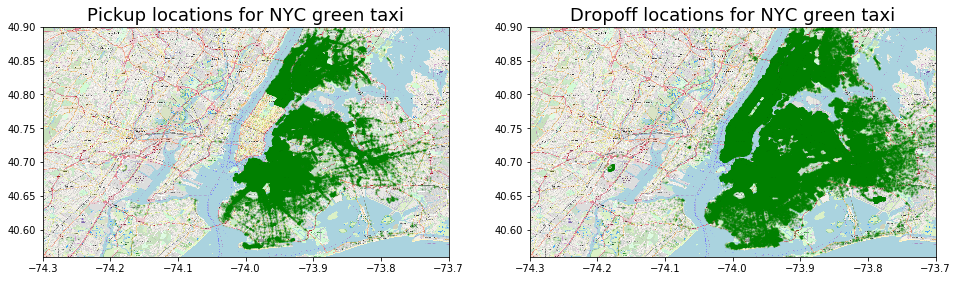

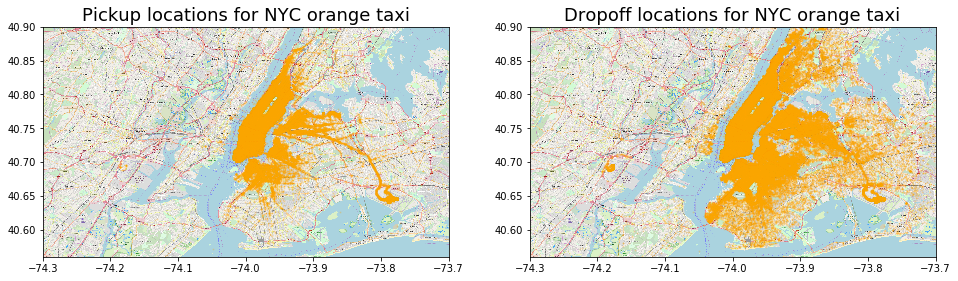

In [27]:
plot_traffic_map(taxi_green_df, LL, nyc_map, color = "green")
plot_traffic_map(taxi_yellow_df, LL, nyc_map, color = "orange")

In [28]:
def plot_traffic(df, LL, color):
    fig, axes = plt.subplots(1, 2, figsize=(18,8))
    axes[0].scatter(df.pickup_longitude, df.pickup_latitude, alpha=0.5, c=color, s=0.01)
    axes[0].set_xlim((LL[0], LL[1]))
    axes[0].set_ylim((LL[2], LL[3]))
    axes[0].set_title('Pickup locations for NYC {} taxi'.format(color), fontsize=24)

    axes[1].scatter(df.dropoff_longitude, df.dropoff_latitude, alpha=0.5, c=color, s=0.01)
    axes[1].set_xlim((LL[0], LL[1]))
    axes[1].set_ylim((LL[2], LL[3]))
    axes[1].set_title('Dropoff locations for NYC {} taxi'.format(color), fontsize=24)

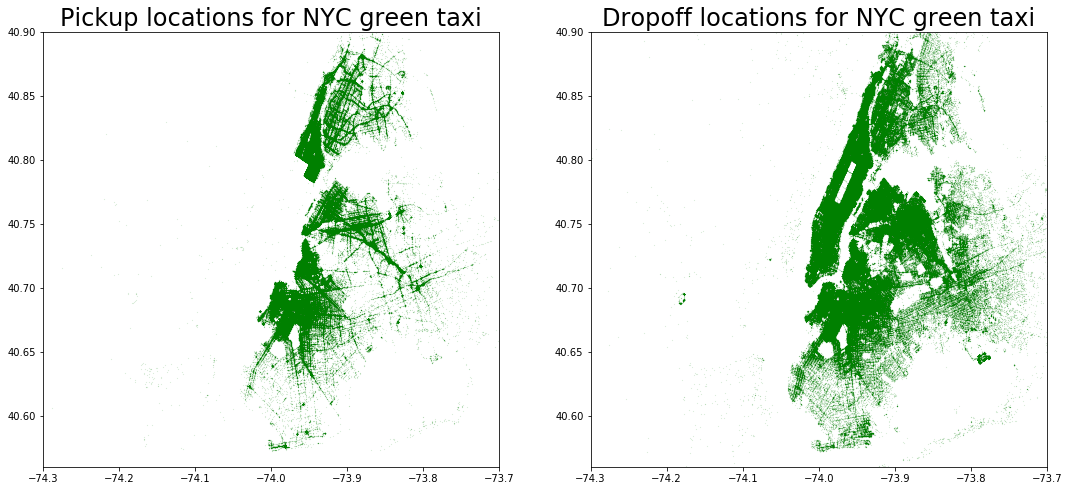

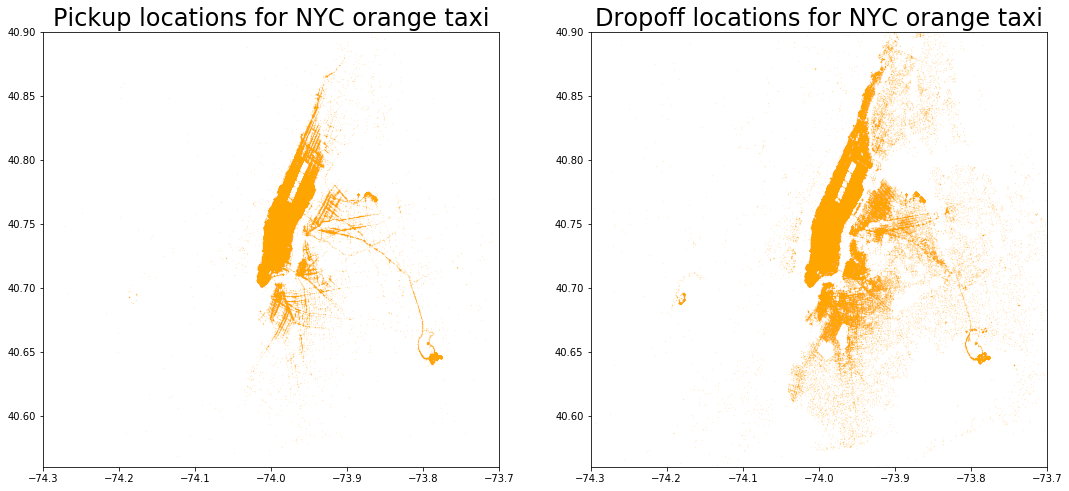

In [29]:
plot_traffic(taxi_green_df, LL, 'green')
plot_traffic(taxi_yellow_df, LL, 'orange')

Based on the geographical maps plotted above, I have discovered several interesting patterns:

1.NYC green taxi has almost zero pickup in upper east side, midtown or downtown Manhattan, consistent with the regulation that green taxi is not allowed to pick up passengers below West 110th and East 96th streets in Manhattan, areas where only yellow taxi is allowed to accept hails.

2.Pickup locations for yellow taxi is highly enriched in upper east side, upper west side, midtown and downtown Manhattan. Yellow taxi also has heavy pickup in JFK and LGA. Green taxi has pickup locations more widely distributed in Harlem, Bronx, Brooklyn and Queens, which almost exhibits an exclusive pattern with yellow taxi pickup distribution. In addition, green taxi has a higher pickup trip density in areas closer to Manhattan compared to regions that are farther away.

3.For both green and yellow taxi, the density map of dropoff locations has a wider and more diluted distribution pattern compared to the pickup density map. Green taxi can drop off passengers in Manhattan and there is also a heavy dropoff in JFK. Dropoff locations for yellow taxi have a wider spread to Brooklyn and Queens, but with a higher dropoff density in areas closer to Manhattan.

### 2.1.2 Analyze the numerical distribution of pickup and dropoff coordinates

Although the maps plotted above can provide a vivid picture of the pickup and dropoff density, the information is limited and not very quantitative. In order to have a better understanding of the distribution of different pickup and dropoff coordinates, I will generate density plot for both longitude and latitude of pickup and dropoff locations for taxi trips.

In [92]:
def plot_long_lat(df, color, title):
    fig, axes = plt.subplots(2,2,figsize = (10,10), sharex=False, sharey = False)
    sns.distplot(df.pickup_longitude, color = color, bins = 200, ax = axes[0,0])
    axes[0,0].set_xlabel('pickup_longitude', fontsize=16)
    sns.distplot(df.pickup_latitude, color = color, bins = 200, ax = axes[0,1])
    axes[0,1].set_xlabel('pickup_latitude', fontsize=16)
    sns.distplot(df.dropoff_longitude, color = color, bins = 200, ax = axes[1,0])
    axes[1,0].set_xlabel('dropoff_longitude', fontsize=16)
    sns.distplot(df.dropoff_latitude, color = color, bins = 200, ax = axes[1,1])
    axes[1,1].set_xlabel('dropoff_latitude', fontsize=16)
    plt.setp(axes, yticks = [])
    fig.suptitle(title, fontsize=18, y =1.05)
    plt.tight_layout()

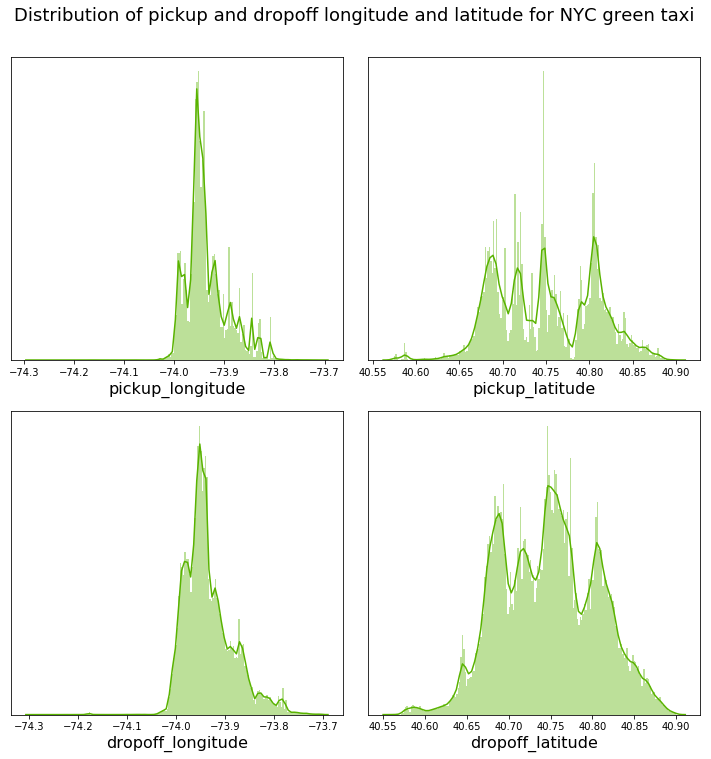

In [93]:
title = 'Distribution of pickup and dropoff longitude and latitude for NYC green taxi'
plot_long_lat(taxi_green_df, '#59b300', title)

In [96]:
def plot_long_lat2(df, title):
    fig, axes = plt.subplots(1,2,figsize = (10,5), sharex=False, sharey = False)
    sns.distplot(df.pickup_longitude, color = 'red', hist = False, ax = axes[0], label = 'pickup')
    sns.distplot(df.dropoff_longitude, color = 'blue', hist = False, ax = axes[0], label = 'dropoff')
    axes[0].set_xlabel('longitude', fontsize=16)
    axes[0].legend()
    
    sns.distplot(df.pickup_latitude, color = 'red', hist = False, ax = axes[1], label = 'pickup')
    sns.distplot(df.dropoff_latitude, color = 'blue', hist = False, ax = axes[1], label = 'dropoff')
    axes[1].set_xlabel('latitude', fontsize=16)
    axes[1].legend()
    
    plt.setp(axes, yticks = [])
    fig.suptitle(title, fontsize=18, y =1.05)
    plt.tight_layout()

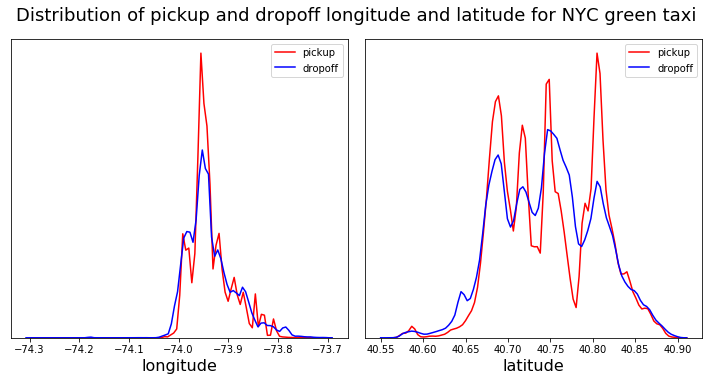

In [97]:
title = 'Distribution of pickup and dropoff longitude and latitude for NYC green taxi'
plot_long_lat2(taxi_green_df, title)

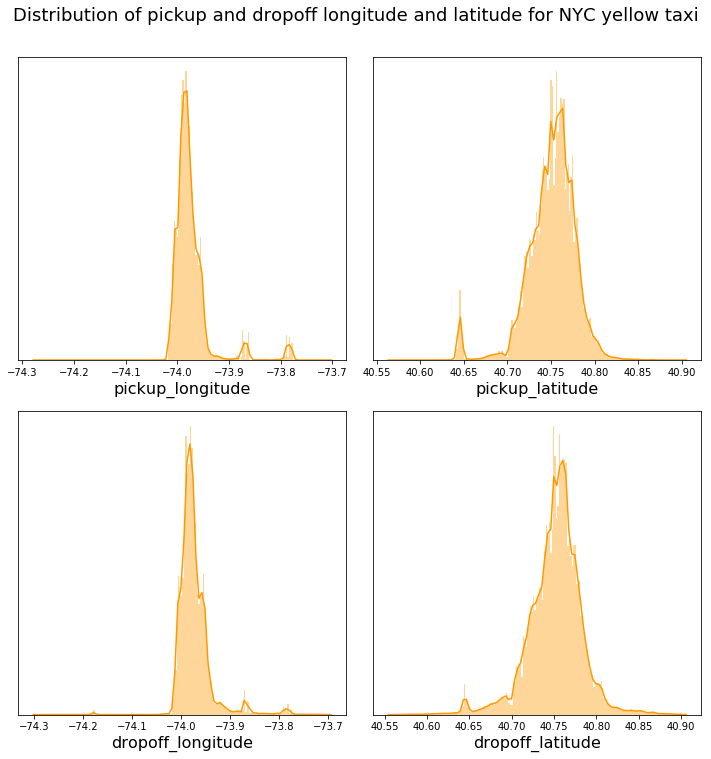

In [98]:
title = 'Distribution of pickup and dropoff longitude and latitude for NYC yellow taxi'
plot_long_lat(taxi_yellow_df, '#ff9900', title)

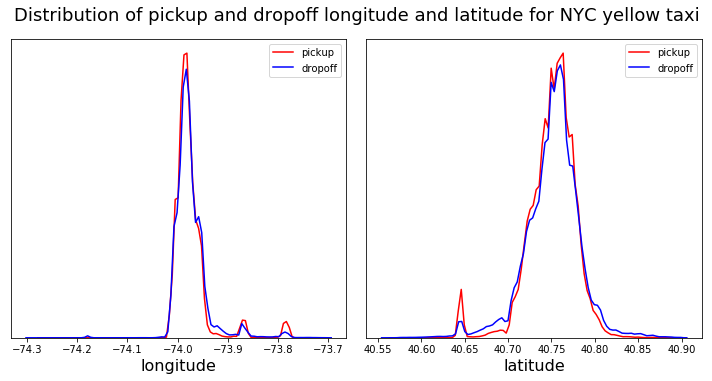

In [99]:
title = 'Distribution of pickup and dropoff longitude and latitude for NYC yellow taxi'
plot_long_lat2(taxi_yellow_df, title)

As shown in the density plots, the numerical distributions of coordinates have very different patterns between green and yellow taxi. 

1.For green taxi, both longitude and latitude distributions have multiple peaks. The longitude  distribution is more centered around a main peak at -73.95 with multiple small peaks next to it spanning from -74.05 to -73.75.The latitude has a wider distribution of 4 peaks with approximately equal height spanning from 40.65 to 40.90. This is consistent with the pickup and dropoff patterns of NYC green taxi visualized in seciton 2.1.1 that green taxi mainly operate in Harlem, Bronx, Brooklyn and Queens. These areas have closer longitude coordinates while the latitude shows larger variation.

2.For both longitude and latitude of green taxi trips, there is no significant difference between pickup and dropoff distributions. However, we do notice that peaks for pickup coordinates are sharper and have better separation from surrounding peaks compared to dropoff coordinates. One possible reason is that the pickup locations are relatively more concentrated (eg. at transportation hubs) while dropoff locations have a wider and more diluted distribution pattern, which is also consistent with the map visualization results. 

3.The distributions of pickup and dropoff coordinates for yellow taxi approximate normal distribution. The longitude has a sharper peak compared to latitude, which can be explained by the shape of Manhattan Island. The longitude is centered around -73.99 and the latitude around 40.75, which corresponds to the coordinates of several busiest transportation hubs in NYC such as the Grand Central Terminal (lat:40.7527, lon:-73.9772) and the Penn Station (lat:40.7506,lon:-73.9936). These altogether sugguest that trips of NYC yellow taxi are heavily concentrated in Manhattan.

4.In addition, there is a small but distinct peak for latitude distribution at 40.64, which corresponds to the coordinate of JFK (lat:40.6413, lon:-73.7781). This also explains the small peak centered around -73.78 for longitude. The other small peak at longitude distribution centered around -73.88 may likely correspond to Jackson Heights (lat:40.7557, lon:-73.8831).

## 2.2 Temporal features
(Summarize total trip and average trip numbers conditioned on day_of_year, day_of_week, hour_of_day, and month)

### 2.2.1 Trip number -- day_of_year

In [31]:
taxi_green_dayofyear = taxi_green_df.groupby(["day_of_year"], as_index = False).count()[["day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_day_green"})
taxi_yellow_dayofyear = taxi_yellow_df.groupby(["day_of_year"], as_index = False).count()[["day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_day_yellow"})
taxi_dayofyear = taxi_green_dayofyear.merge(taxi_yellow_dayofyear, left_on = 'day_of_year', right_on = 'day_of_year')

In [125]:
taxi_dayofyear.head()

day_of_year  tripnum_day_green  tripnum_day_yellow
0            1               3327                2564
1            2               2288                2254
2            3               2711                2707
3            4               2127                2213
4            5               2169                2438

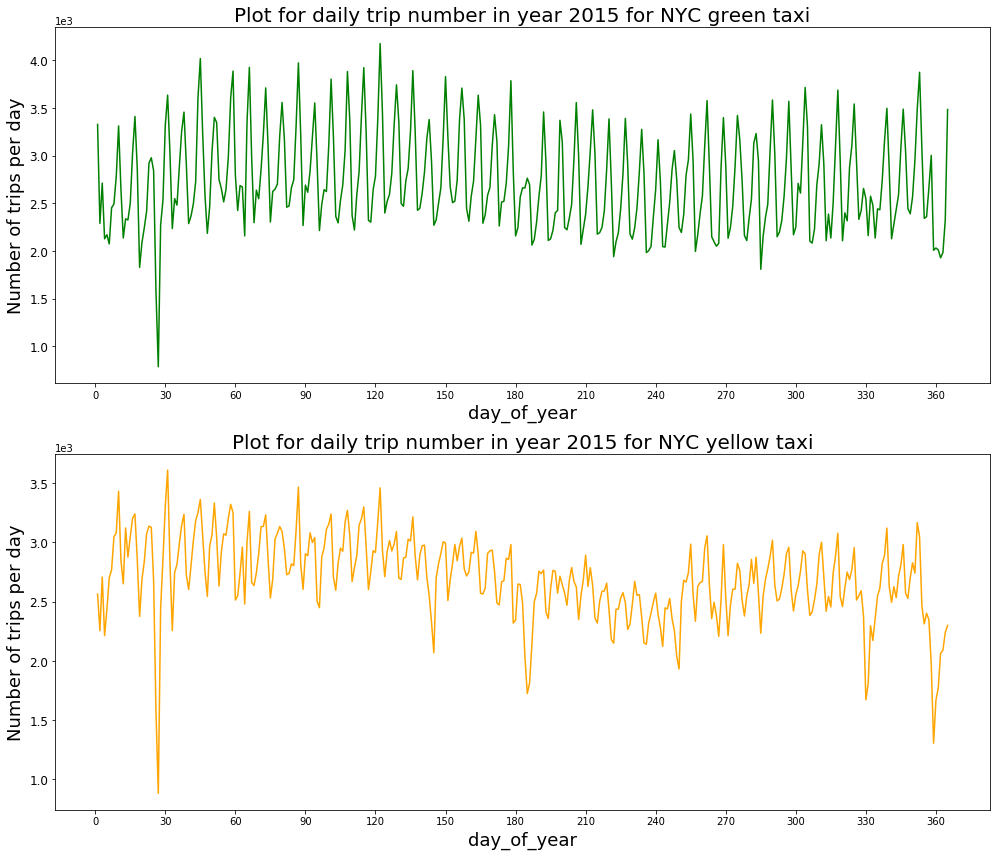

In [32]:
colors = ['green', 'orange']
taxi = ['green', 'yellow']
fig = plt.figure(figsize = (14,12))
for i in np.arange(2):
    plt.subplot(2,1,i+1)
    plt.plot(taxi_dayofyear.day_of_year, taxi_dayofyear.iloc[:,i+1], color = colors[i])
    plt.xlabel('day_of_year', fontsize = 18)
    plt.ylabel('Number of trips per day', fontsize = 18)
    plt.xticks(np.arange(0,365, 30))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.yticks(size=12)
    plt.title('Plot for daily trip number in year 2015 for NYC {} taxi'.format(taxi[i]), fontsize = 20)
fig.tight_layout()

In [33]:
max_id = taxi_dayofyear['tripnum_day_green'].values.argmax()
min_id = taxi_dayofyear['tripnum_day_green'].values.argmin()
max_day = taxi_dayofyear.iloc[max_id,]['day_of_year']
min_day = taxi_dayofyear.iloc[min_id,]['day_of_year']
max_date = datetime.datetime(2015, 1, 1) + datetime.timedelta(int(max_day) - 1)
min_date = datetime.datetime(2015, 1, 1) + datetime.timedelta(int(min_day) - 1)
max_tripnum = taxi_dayofyear['tripnum_day_green'].values.max()
min_tripnum = taxi_dayofyear['tripnum_day_green'].values.min()

print('Date {} of year 2015 has the highest trip number for NYC green taxi: {}'.format(max_date.strftime("%m/%d"), max_tripnum))
print('Date {} of year 2015 has the lowest trip number for NYC green taxi: {}'.format(min_date.strftime("%m/%d"), min_tripnum))

Date 05/02 of year 2015 has the highest trip number for NYC green taxi: 4175
Date 01/27 of year 2015 has the lowest trip number for NYC green taxi: 784


In [34]:
max_id = taxi_dayofyear['tripnum_day_yellow'].values.argmax()
min_id = taxi_dayofyear['tripnum_day_yellow'].values.argmin()
max_day = taxi_dayofyear.iloc[max_id,]['day_of_year']
min_day = taxi_dayofyear.iloc[min_id,]['day_of_year']
max_date = datetime.datetime(2015, 1, 1) + datetime.timedelta(int(max_day) - 1)
min_date = datetime.datetime(2015, 1, 1) + datetime.timedelta(int(min_day) - 1)
max_tripnum = taxi_dayofyear['tripnum_day_yellow'].values.max()
min_tripnum = taxi_dayofyear['tripnum_day_yellow'].values.min()

print('Date {} of year 2015 has the highest trip number for NYC yellow taxi: {}'.format(max_date.strftime("%m/%d"), max_tripnum))
print('Date {} of year 2015 has the lowest trip number for NYC yellow taxi: {}'.format(min_date.strftime("%m/%d"), min_tripnum))

Date 01/31 of year 2015 has the highest trip number for NYC yellow taxi: 3608
Date 01/27 of year 2015 has the lowest trip number for NYC yellow taxi: 883


**Question**: What happend on 01/27/2015?
### The Blizzard of January 26-27, 2015
reference: https://www.weather.gov/okx/Blizzard_01262715
<img src="https://www.weather.gov/images/okx/Blizzard_01262715//header.png" width=600px>

**Note**: The date with highest and lowest trip number for green and yellow taxi computed using the randomly selected 1000000 trip records is the same as the summarizing data of the entire dataset. The fluctuation pattern also looks very similar using the selected data or the original dataset. This suggests that the 1000000 data points that we randomly extract is representative of the entire dataset and can be used for further downstream analysis.

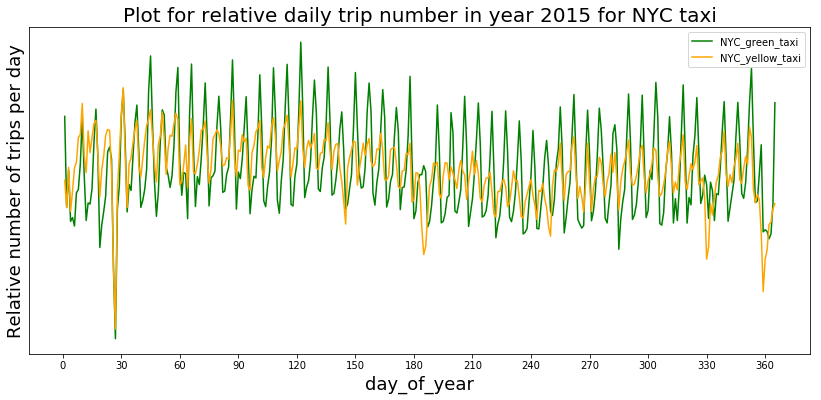

In [36]:
colors = ['green', 'orange']
fig = plt.figure(figsize = (14,6))
plt.plot(taxi_dayofyear.day_of_year, taxi_dayofyear.tripnum_day_green/taxi_dayofyear.tripnum_day_green.sum(), color = colors[0], label='NYC_green_taxi')
plt.plot(taxi_dayofyear.day_of_year, taxi_dayofyear.tripnum_day_yellow/taxi_dayofyear.tripnum_day_yellow.sum(), color = colors[1], label='NYC_yellow_taxi')
plt.xlabel('day_of_year', fontsize = 18)
plt.ylabel('Relative number of trips per day', fontsize = 18)
plt.xticks(np.arange(0,365, 30))
plt.yticks([])
plt.title('Plot for relative daily trip number in year 2015 for NYC taxi', fontsize = 20)
plt.legend()

### 2.2.2 Trip number -- day_of_week

In [37]:
taxi_green_weekday = taxi_green_df.groupby(["weekday"], as_index = False).count()[["weekday", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_dayofweek_green"})
taxi_yellow_weekday = taxi_yellow_df.groupby(["weekday"], as_index = False).count()[["weekday", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_dayofweek_yellow"})
taxi_weekday = taxi_green_weekday.merge(taxi_yellow_weekday, left_on = 'weekday', right_on = 'weekday')

In [38]:
taxi_weekday.head()

weekday  tripnum_dayofweek_green  tripnum_dayofweek_yellow
0        0                   115123                    126453
1        1                   118301                    135715
2        2                   127105                    141877
3        3                   142040                    146725
4        4                   158724                    148086

In [39]:
weekday_dict = {1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', 0:'Mon'}

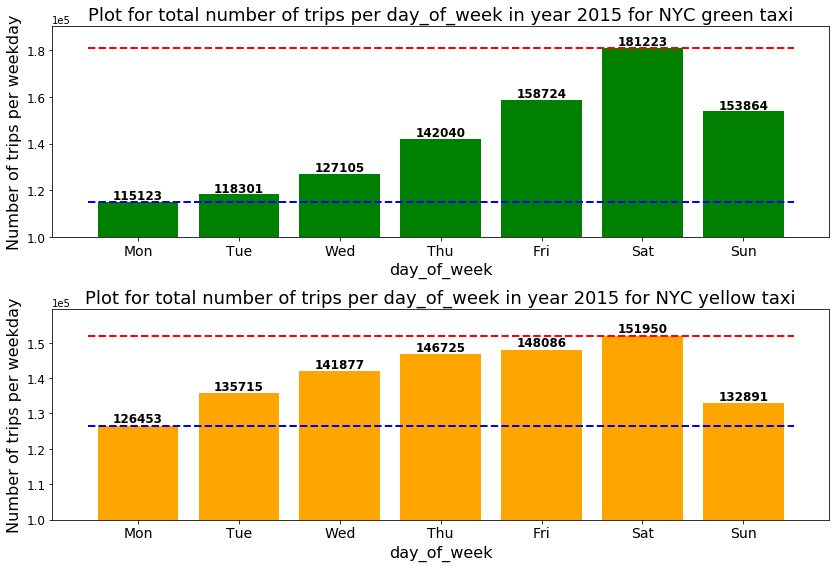

In [61]:
colors = ['green', 'orange']
taxi = ['green', 'yellow']
fig = plt.figure(figsize = (12,8))
for i in np.arange(2):
    ax = fig.add_subplot(2,1,i+1)
    plt.bar(taxi_weekday.weekday, taxi_weekday.iloc[:,i+1], color = colors[i])
    plt.xlabel('day_of_week', fontsize = 16)
    plt.ylabel('Number of trips per weekday', fontsize = 16)
    plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), size=14)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.yticks(size=12)
    plt.ylim(100000)
    for n, v in enumerate(taxi_weekday.iloc[:,i+1]):
        ax.text(n, v + 1000, str(v), fontweight='bold', fontsize=12, ha = 'center')
    ax.plot([-0.5, 6.5], [taxi_weekday.iloc[:,i+1].min(), taxi_weekday.iloc[:,i+1].min()], "k--", linewidth=2, color = 'blue')
    ax.plot([-0.5, 6.5], [taxi_weekday.iloc[:,i+1].max(), taxi_weekday.iloc[:,i+1].max()], "k--", linewidth=2, color = 'red')
    plt.title('Plot for total number of trips per day_of_week in year 2015 for NYC {} taxi'.format(taxi[i]), fontsize = 18)
    
fig.tight_layout()

Next, instead of plotting the total number of trips on each day of week, I generated bargraph for the average daily trip number grouped by day_of_week and also plotted the standard deviation.

Text(0.5, 1.0, 'Plot for average number of trips per day_of_week in year 2015 for NYC taxi')

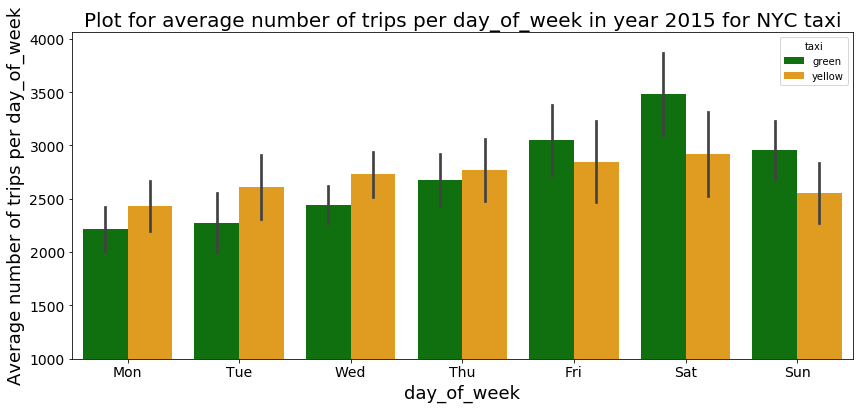

In [58]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_df_g = taxi_green_df.groupby(["day_of_year", "weekday"], as_index = False).count()[["weekday", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum"})
taxi_df_y = taxi_yellow_df.groupby(["day_of_year", "weekday"], as_index = False).count()[["weekday", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum"})
taxi_df_g['taxi'] = np.array(['green']*taxi_df_g.shape[0])
taxi_df_y['taxi'] = np.array(['yellow']*taxi_df_y.shape[0])
taxi_weekday_df = pd.concat([taxi_df_g, taxi_df_y])

sns.barplot(x = 'weekday', y = 'tripnum', hue = 'taxi', data = taxi_weekday_df, ci='sd', ax = ax, palette = ['green', 'orange'])
plt.xlabel('day_of_week', fontsize = 18)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), size=14)
plt.ylabel('Average number of trips per day_of_week', fontsize = 18)
plt.yticks(size=14)
plt.ylim(1000)
plt.title('Plot for average number of trips per day_of_week in year 2015 for NYC taxi', fontsize = 20)

Consistent with the findings of the summary data in the last notebook, both NYC green and yellow taxi have trip peaks on Saturday with the lowest trip number on Monday. Green taxi has a more dramatic temporal change with around 3500 daily trips on Saturday that drops to around 2200 on Monday, while yellow taxi remains a relatively constant daily trip number on each day of week.

### 2.2.3 Trip number -- hour

Since weekend has very different trip patterns from weekday, it's not very useful to just look at the total number of trips for each hour of the day. Instead, I will analyze how hourly trip number fluctuates conditioned on day of week. 

Text(0.5, 1.0, 'Number of trips per hour conditioned on day_of_week for NYC green taxi')

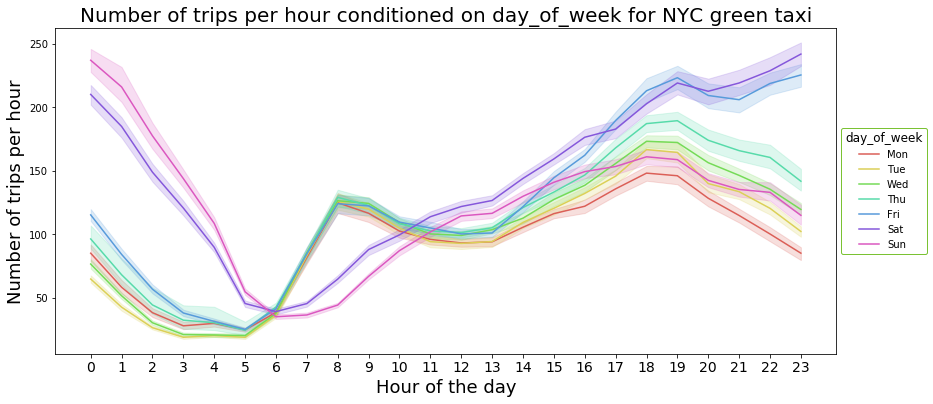

In [63]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
train_df_green_day_hour = taxi_green_df.groupby(["day_of_year","hour", "weekday"], as_index = False).count()[["weekday", "hour", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "trip_number_green"})
sns.lineplot(x = 'hour', y = 'trip_number_green', hue = 'weekday',data = train_df_green_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(size=14)
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Number of trips per hour conditioned on day_of_week for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Number of trips per hour conditioned on day_of_week for NYC yellow taxi')

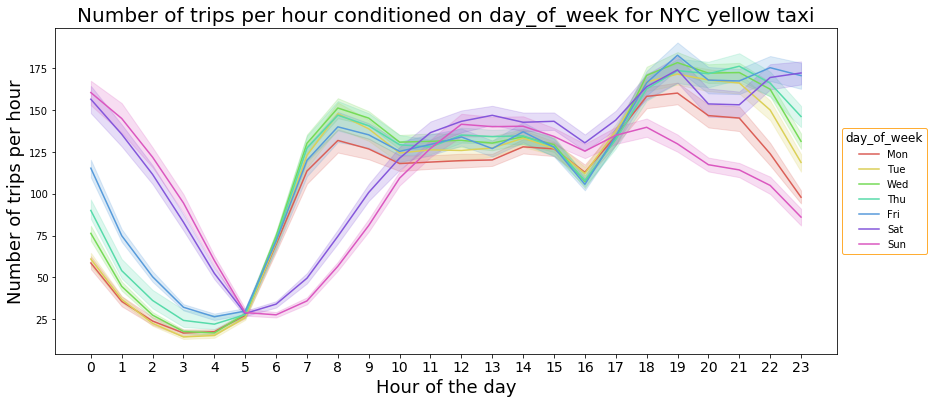

In [64]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
train_df_yellow_day_hour = taxi_yellow_df.groupby(["day_of_year","hour", "weekday"], as_index = False).count()[["weekday", "hour", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "trip_number_yellow"})
sns.lineplot(x = 'hour', y = 'trip_number_yellow', hue = 'weekday',data = train_df_yellow_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(np.arange(24), size=14)
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Number of trips per hour conditioned on day_of_week for NYC yellow taxi', fontsize = 20)

### 2.2.4 Trip number -- month

In [53]:
taxi_green_month = taxi_green_df.groupby(["month"], as_index = False).count()[["month", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_month_green"})
taxi_yellow_month = taxi_yellow_df.groupby(["month"], as_index = False).count()[["month", "trip_ID"]].rename(columns = {"trip_ID": "tripnum_month_yellow"})
taxi_month = taxi_green_month.merge(taxi_yellow_month, left_on = 'month', right_on = 'month')

In [54]:
taxi_month.head()

month  tripnum_month_green  tripnum_month_yellow
0      1                78411                 85625
1      2                81571                 83150
2      3                89323                 89258
3      4                86030                 87925
4      5                92483                 88577

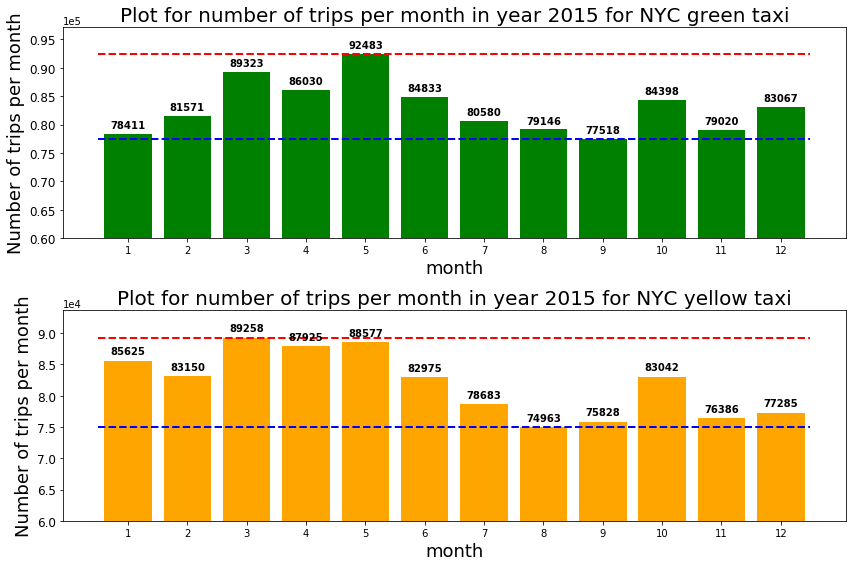

In [56]:
colors = ['green', 'orange']
taxi = ['green', 'yellow']
fig = plt.figure(figsize = (12,8))
for i in np.arange(2):
    ax = fig.add_subplot(2,1,i+1)
    plt.bar(taxi_month.month, taxi_month.iloc[:,i+1], color = colors[i])
    plt.xlabel('month', fontsize = 18)
    plt.ylabel('Number of trips per month', fontsize = 18)
    plt.xticks(np.arange(0,12)+1)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.yticks(size=12)
    plt.ylim(60000)
    for n, v in enumerate(taxi_month.iloc[:,i+1]):
        ax.text(n+1, v + 1000, str(v), fontweight='bold', fontsize=10, ha = 'center')
    ax.plot([0.5, 12.5], [taxi_month.iloc[:,i+1].min(), taxi_month.iloc[:,i+1].min()], "k--", linewidth=2, color = 'blue')
    ax.plot([0.5, 12.5], [taxi_month.iloc[:,i+1].max(), taxi_month.iloc[:,i+1].max()], "k--", linewidth=2, color = 'red')
    plt.title('Plot for number of trips per month in year 2015 for NYC {} taxi'.format(taxi[i]), fontsize = 20)
    
fig.tight_layout()

Similarly, the total number of trips per month has a similar distribution between the randomly selected 1000000 data points and the summarizing data of the entire dataset.

Text(0.5, 1.0, 'Plot for daily number of trips each month in year 2015 for NYC taxi')

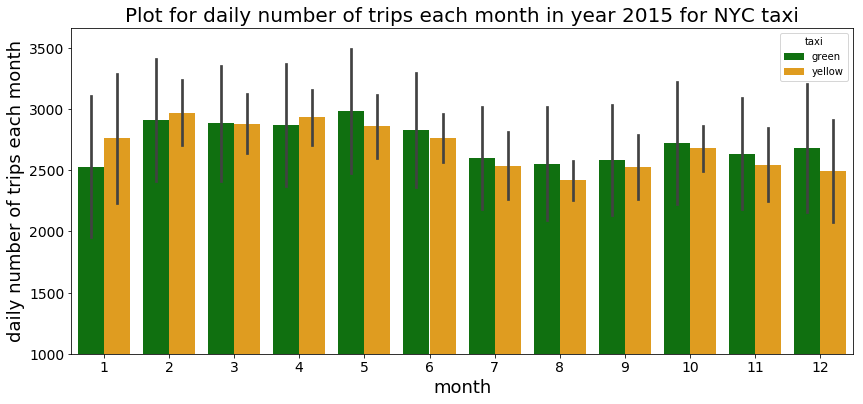

In [60]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_df_g = taxi_green_df.groupby(["day_of_year", "month"], as_index = False).count()[["month", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum"})
taxi_df_y = taxi_yellow_df.groupby(["day_of_year", "month"], as_index = False).count()[["month", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "tripnum"})
taxi_df_g['taxi'] = np.array(['green']*taxi_df_g.shape[0])
taxi_df_y['taxi'] = np.array(['yellow']*taxi_df_y.shape[0])
taxi_month_df = pd.concat([taxi_df_g, taxi_df_y])

sns.barplot(x = 'month', y = 'tripnum', hue = 'taxi', data = taxi_month_df, ci='sd', ax = ax, palette = ['green', 'orange'])
plt.xlabel('month', fontsize = 18)
plt.xticks(np.arange(12), fontsize=14)
plt.ylabel('daily number of trips each month', fontsize = 18)
plt.yticks(size=14)
plt.ylim(1000)
plt.title('Plot for daily number of trips each month in year 2015 for NYC taxi', fontsize = 20)

## 2.3 Intrinsic trip features
(Trip distance, trip duration, trip fare and speed)

In [100]:
taxi_green_df['trip_distance'].describe()

count    996380.000000
mean          2.905067
std           2.944175
min           0.010000
25%           1.100000
50%           1.940000
75%           3.670000
max         640.100000
Name: trip_distance, dtype: float64

As we can see, there are some extremely large values for certain types of data and it's better to remove these outliers when we look at data distribution. Besides, in order to better visualize the data, both original data and `log` transformed data are plotted for both green and yellow taxi datasets for better comparison.

In [117]:
def plot_distribution(df_list, col, bins, title, xlabel):
    colors = ['#59b300', '#ff9900']
    taxi = ['green', 'yellow']
    fig, axes = plt.subplots(3,2,figsize = (8,12), sharex=False, sharey = False)
    for i in np.arange(2):
        sns.distplot(df_list[i][col], color = colors[i], bins = bins, ax = axes[i,0])
        axes[i,0].set_xlabel('{}/{} taxi'.format(xlabel, taxi[i]), fontsize=12)
        sns.distplot(np.log(df_list[i][col]+1), color = colors[i], bins = bins, ax = axes[i,1])
        axes[i,1].set_xlabel('log({})/{} taxi'.format(xlabel, taxi[i]), fontsize=12)
    
    for i in np.arange(2):
        sns.distplot(df_list[i][col], color = colors[i], hist = False, ax = axes[2,0], label = '{} taxi'.format(taxi[i]))
    axes[2,0].legend()
    axes[2,0].set_xlabel(xlabel, fontsize=12)
    
    for i in np.arange(2):
        sns.distplot(np.log(df_list[i][col]+1), color = colors[i], hist = False, ax = axes[2,1], label = '{} taxi'.format(taxi[i]))
    axes[2,1].legend()
    axes[2,1].set_xlabel('log({})'.format(xlabel), fontsize=12)
    
    plt.setp(axes, yticks = [])
    fig.suptitle(title, fontsize=18, y =1.02)
    plt.tight_layout()

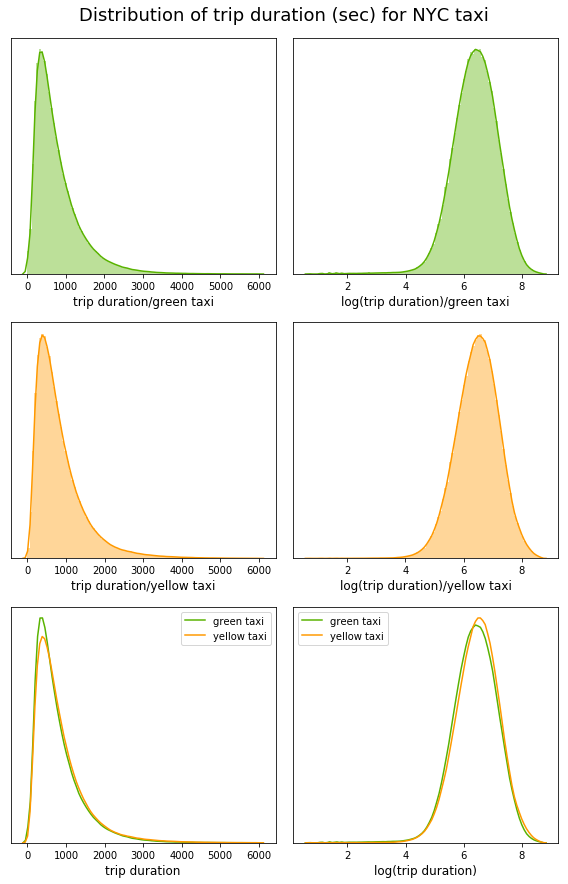

In [118]:
df_list = [taxi_green_df[taxi_green_df.trip_duration_sec < 6000], taxi_yellow_df[taxi_yellow_df.trip_duration_sec < 6000]]
col = 'trip_duration_sec'
title = 'Distribution of trip duration (sec) for NYC taxi'
plot_distribution(df_list, col, 100, title, 'trip duration')

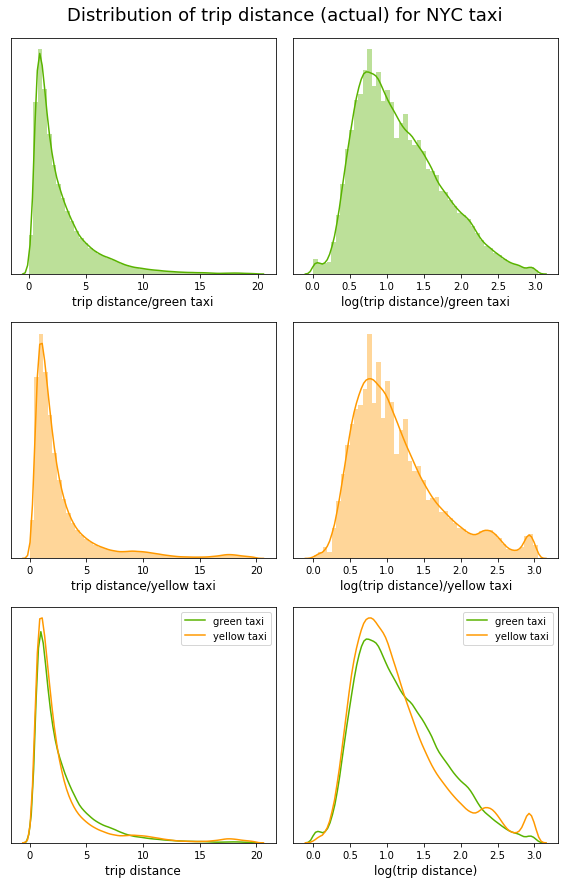

In [192]:
col = 'trip_distance'
df_list = [taxi_green_df[taxi_green_df[col] < 20], taxi_yellow_df[taxi_yellow_df[col] < 20]]
title = 'Distribution of trip distance (actual) for NYC taxi'
plot_distribution(df_list, col, 50, title, 'trip distance')

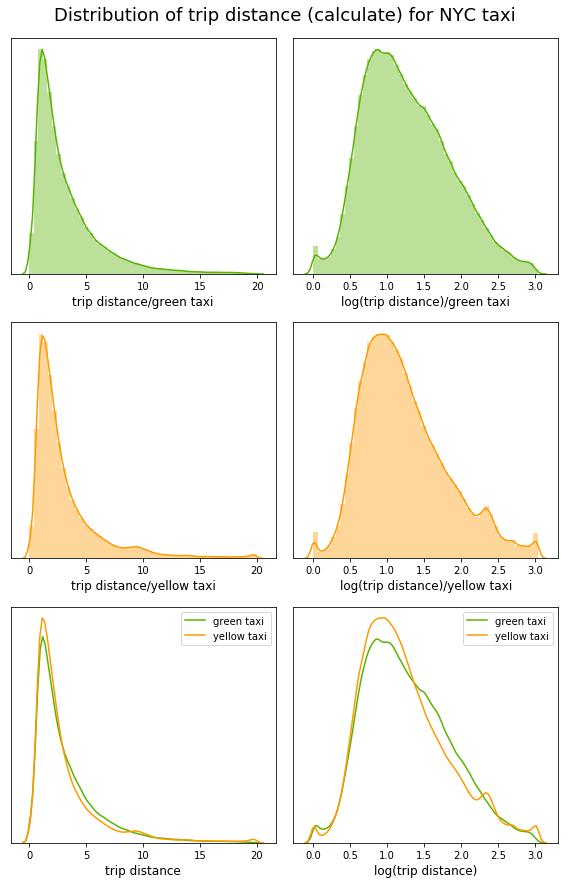

In [191]:
col = 'distance_cal'
df_list = [taxi_green_df[taxi_green_df[col] < 20], taxi_yellow_df[taxi_yellow_df[col] < 20]]
title = 'Distribution of trip distance (calculate) for NYC taxi'
plot_distribution(df_list, col, 50, title, 'trip distance')

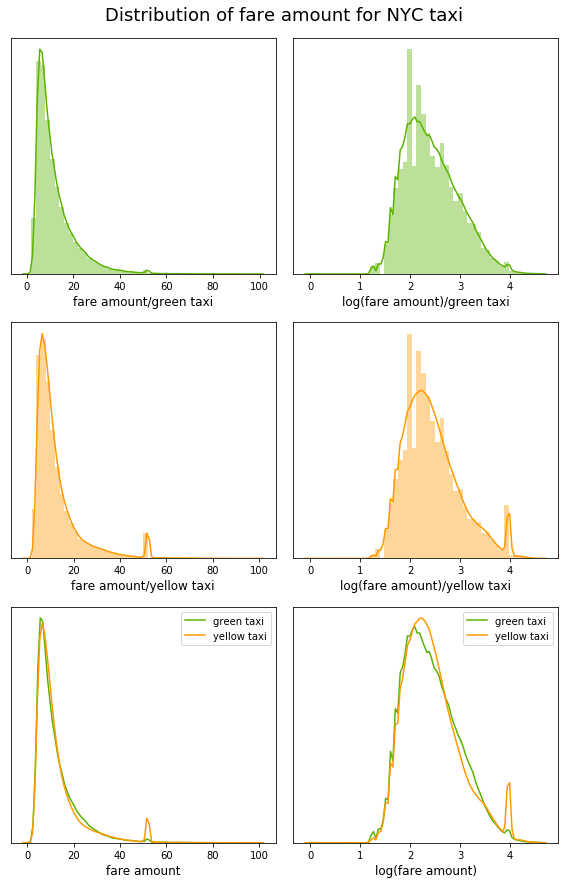

In [120]:
col = 'fare_amount'
df_list = [taxi_green_df[taxi_green_df[col] <= 100], taxi_yellow_df[taxi_yellow_df[col] <= 100]]
title = 'Distribution of fare amount for NYC taxi'
plot_distribution(df_list, col, 50, title, 'fare amount')

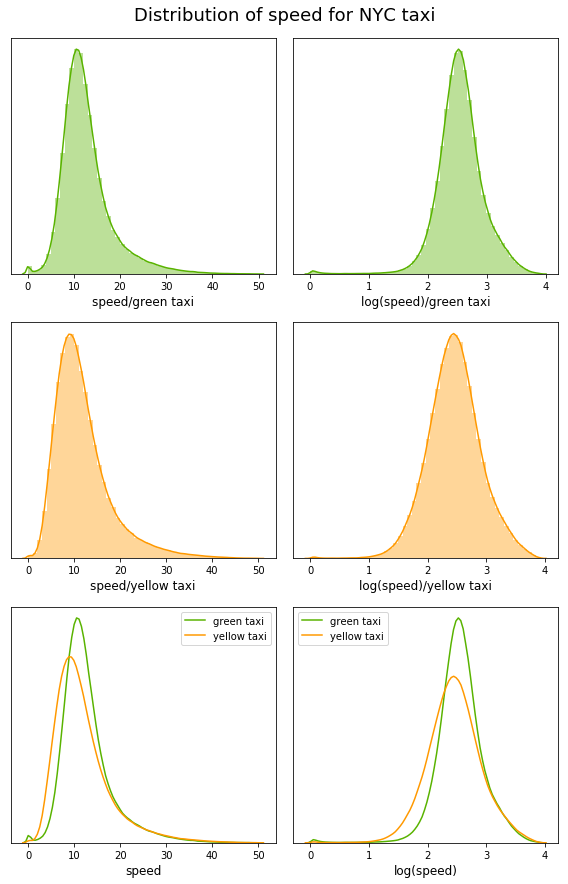

In [190]:
col = 'speed'
df_list = [taxi_green_df[taxi_green_df[col] <= 50], taxi_yellow_df[taxi_yellow_df[col] <= 50]]
title = 'Distribution of speed for NYC taxi'
plot_distribution(df_list, col, 50, title, 'speed')

## 2.4 Trip direction

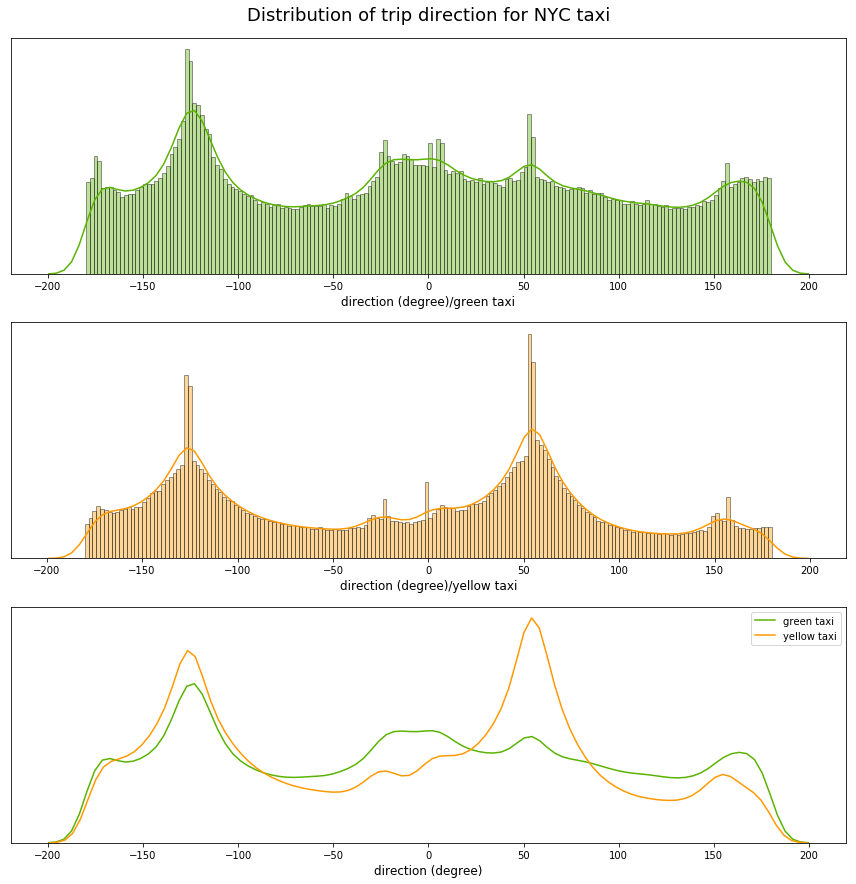

In [62]:
colors = ['#59b300', '#ff9900']
taxi = ['green', 'yellow']
df_list = [taxi_green_df, taxi_yellow_df]
fig, axes = plt.subplots(3,1,figsize = (12,12), sharex=False, sharey = False)
for i in np.arange(2):
    sns.distplot(df_list[i]['direction_cal'], color = colors[i], bins = 180, hist_kws={'edgecolor':'black'}, ax = axes[i])
    axes[i].set_xlabel('{}/{} taxi'.format('direction (degree)', taxi[i]), fontsize=12)
    

for i in np.arange(2):
    sns.distplot(df_list[i]['direction_cal'], color = colors[i], hist = False, ax = axes[2], label = '{} taxi'.format(taxi[i]))
axes[2].legend()
axes[2].set_xlabel('direction (degree)', fontsize=12)
    
plt.setp(axes, yticks = [])
fig.suptitle('Distribution of trip direction for NYC taxi', fontsize=18, y =1.02)
plt.tight_layout()

The two major peaks in trip direction for yellow taxi center around 60 and -120 degree respectively. This aligns with the long axis of Manhattan with 60 corresponding to uptown trips and -120 corresponding to downtown trips. Green taxi still has the direction peak centered around -120 degree while the 60 degree peak is not very distinct. This suggests that there are more trips heading downtown compared to updown for green taxi. Since green taxi mainly operates in regions outside Manhanttan, distribution of trip direction has a more uniform distribution except for the peak at -120 degree.

# 3. Exploratory data analysis -- Joint analysis of multiple feature groups

## 3.1 Trip distance, trip duration, trip fare and speed -- temperal pattern

Text(0.5, 1.0, 'Number of trips per hour conditioned on day_of_week for NYC green taxi')

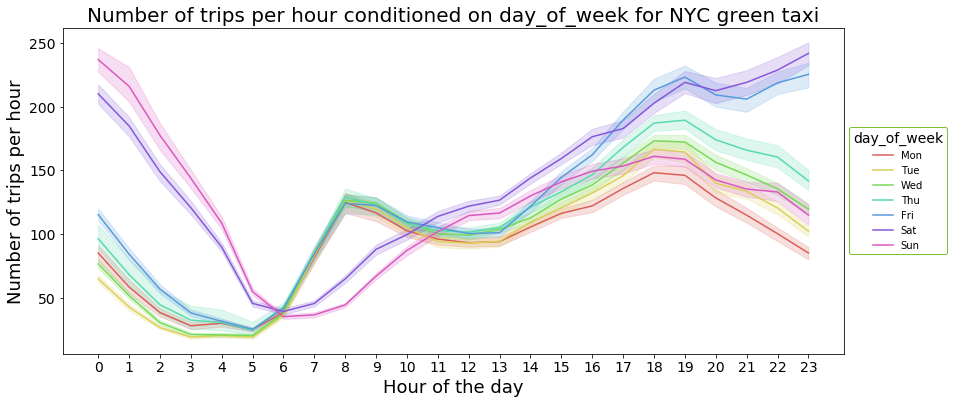

In [65]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
train_df_green_day_hour = taxi_green_df.groupby(["day_of_year","hour", "weekday"], as_index = False).count()[["weekday", "hour", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "trip_number_green"})
sns.lineplot(x = 'hour', y = 'trip_number_green', hue = 'weekday',data = train_df_green_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Number of trips per hour conditioned on day_of_week for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Number of trips per hour conditioned on day_of_week for NYC yellow taxi')

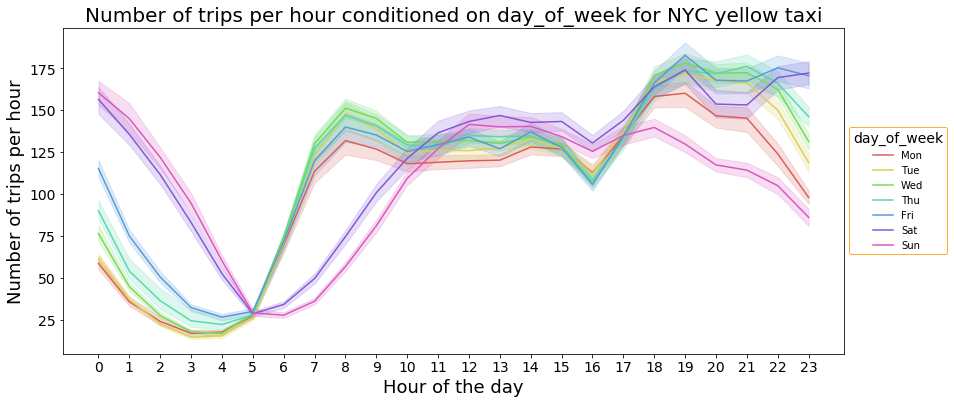

In [67]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
train_df_yellow_day_hour = taxi_yellow_df.groupby(["day_of_year","hour", "weekday"], as_index = False).count()[["weekday", "hour", "day_of_year", "trip_ID"]].rename(columns = {"trip_ID": "trip_number_green"})
sns.lineplot(x = 'hour', y = 'trip_number_green', hue = 'weekday',data = train_df_yellow_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Number of trips per hour conditioned on day_of_week for NYC yellow taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(trip_duration) conditioned on day_of_week versus hour of the day \n for NYC green taxi')

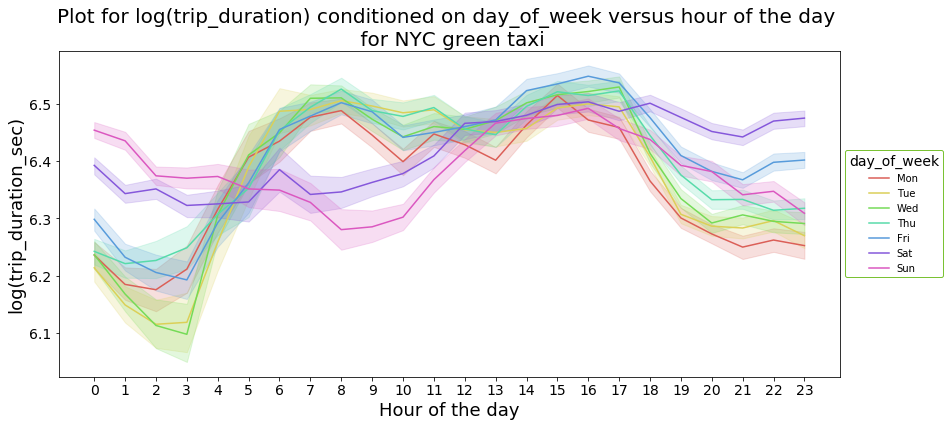

In [66]:
taxi_green_df['trip_duration_sec_log'] = np.log(taxi_green_df.trip_duration_sec)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'trip_duration_sec_log', hue = 'weekday',data = taxi_green_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(trip_duration_sec)', fontsize = 18)
plt.title('Plot for log(trip_duration) conditioned on day_of_week versus hour of the day \n for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(trip_duration) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi')

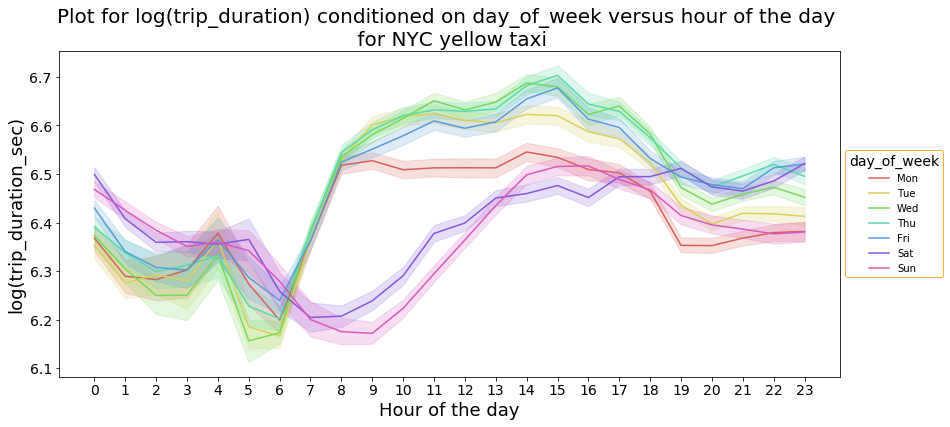

In [68]:
taxi_yellow_df['trip_duration_sec_log'] = np.log(taxi_yellow_df.trip_duration_sec)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'trip_duration_sec_log', hue = 'weekday',data = taxi_yellow_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(trip_duration_sec)', fontsize = 18)
plt.title('Plot for log(trip_duration) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(speed) conditioned on day_of_week versus hour of the day \n for NYC green taxi')

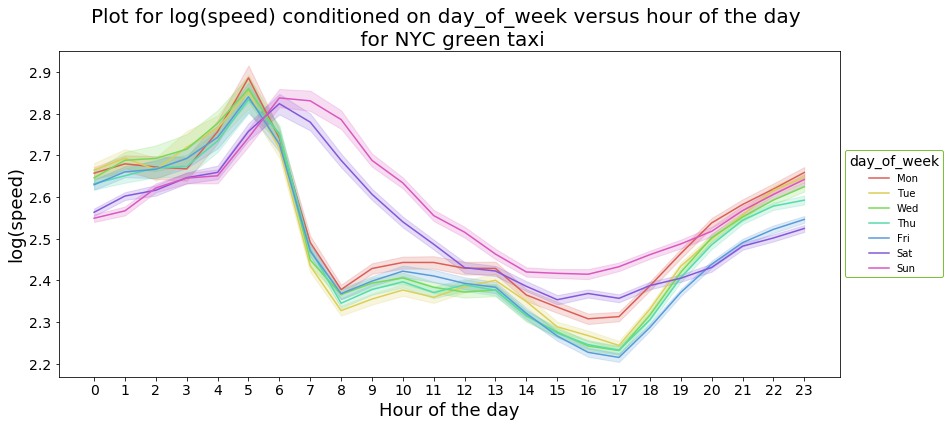

In [69]:
taxi_green_df['speed_log'] = np.log(taxi_green_df.speed)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'speed_log', hue = 'weekday',data = taxi_green_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(speed)', fontsize = 18)
plt.title('Plot for log(speed) conditioned on day_of_week versus hour of the day \n for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(speed) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi')

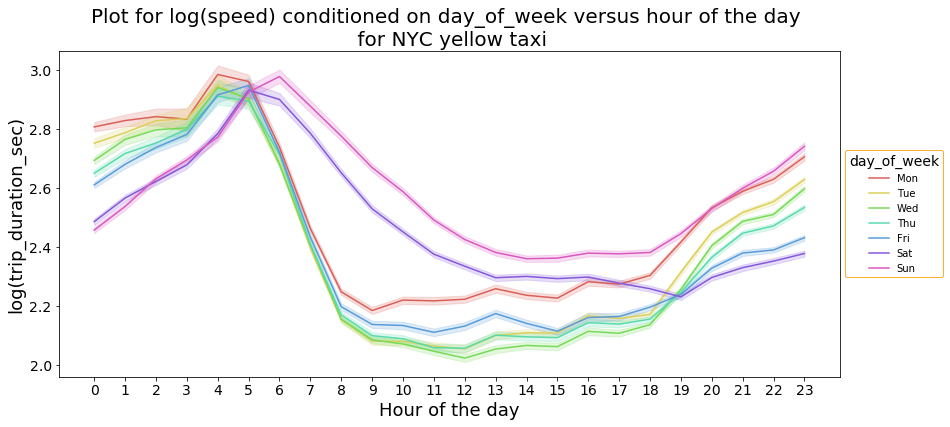

In [70]:
taxi_yellow_df['speed_log'] = np.log(taxi_yellow_df.speed)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'speed_log', hue = 'weekday',data = taxi_yellow_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(trip_duration_sec)', fontsize = 18)
plt.title('Plot for log(speed) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(trip_distance) conditioned on day_of_week versus hour of the day \n for NYC green taxi')

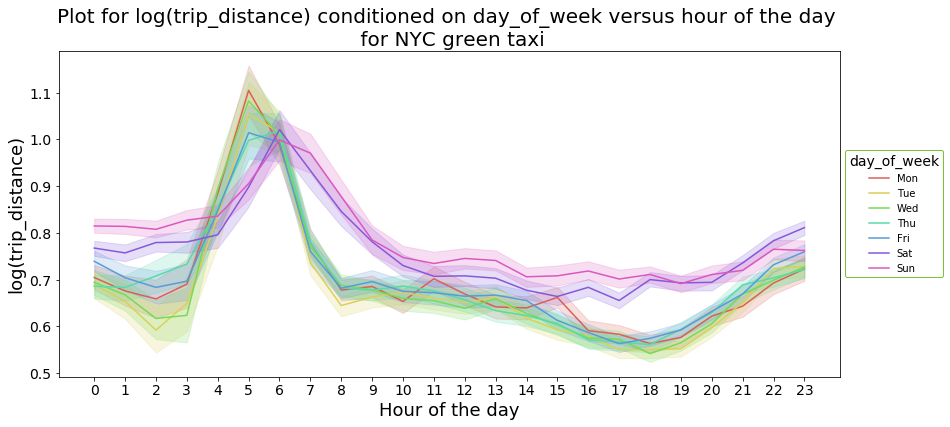

In [72]:
taxi_green_df['trip_distance_log'] = np.log(taxi_green_df.trip_distance)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'trip_distance_log', hue = 'weekday',data = taxi_green_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(trip_distance)', fontsize = 18)
plt.title('Plot for log(trip_distance) conditioned on day_of_week versus hour of the day \n for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(trip_distance) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi')

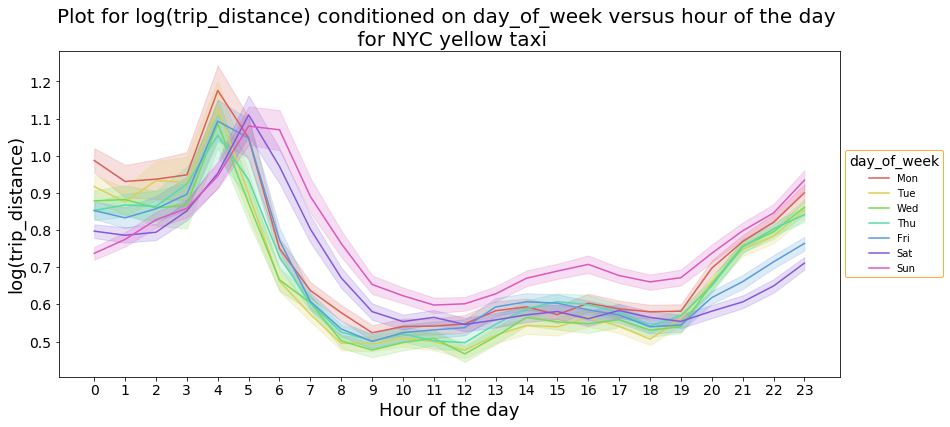

In [73]:
taxi_yellow_df['trip_distance_log'] = np.log(taxi_yellow_df.trip_distance)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'trip_distance_log', hue = 'weekday',data = taxi_yellow_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(trip_distance)', fontsize = 18)
plt.title('Plot for log(trip_distance) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(fare_amount) conditioned on day_of_week versus hour of the day \n for NYC green taxi')

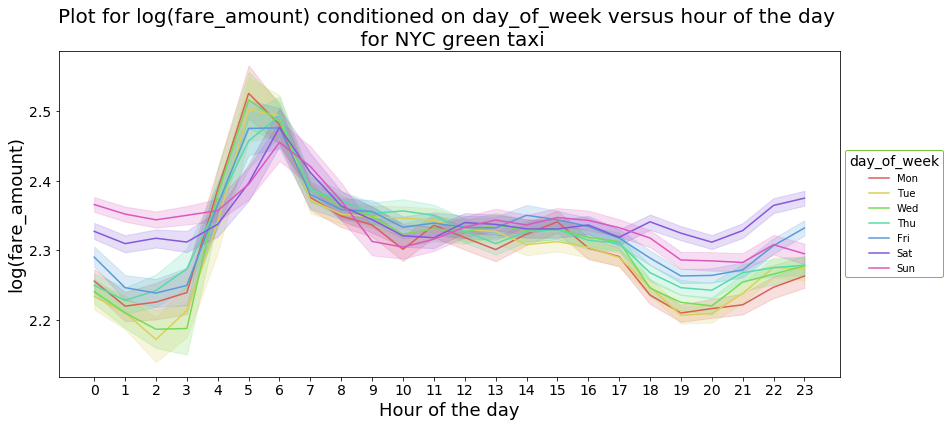

In [74]:
taxi_green_df['fare_amount_log'] = np.log(taxi_green_df.fare_amount)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'fare_amount_log', hue = 'weekday',data = taxi_green_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(fare_amount)', fontsize = 18)
plt.title('Plot for log(fare_amount) conditioned on day_of_week versus hour of the day \n for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Plot for log(fare_amount) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi')

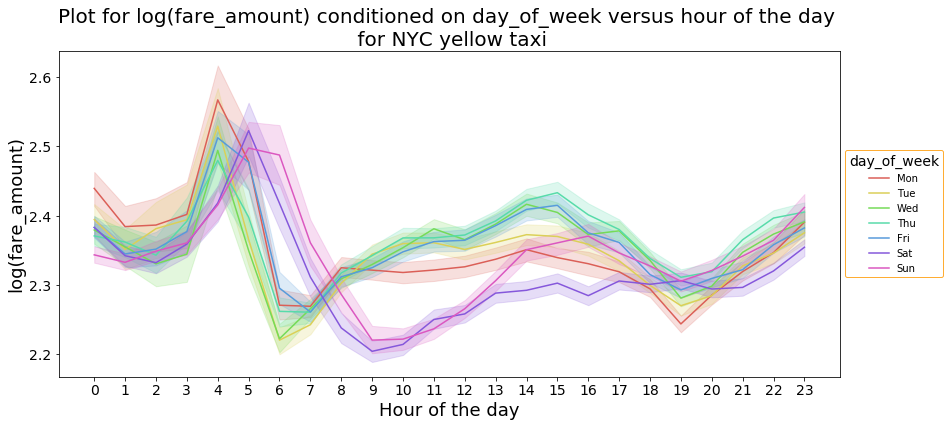

In [75]:
taxi_yellow_df['fare_amount_log'] = np.log(taxi_yellow_df.fare_amount)

fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
sns.lineplot(x = 'hour', y = 'fare_amount_log', hue = 'weekday',data = taxi_yellow_df, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 14, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.yticks(size=14)
plt.ylabel('log(fare_amount)', fontsize = 18)
plt.title('Plot for log(fare_amount) conditioned on day_of_week versus hour of the day \n for NYC yellow taxi', fontsize = 20)

## 3.2 Correlations between trip distance, trip duration and trip fare

### 3.2.1 Trip distance (actual versus calculated)

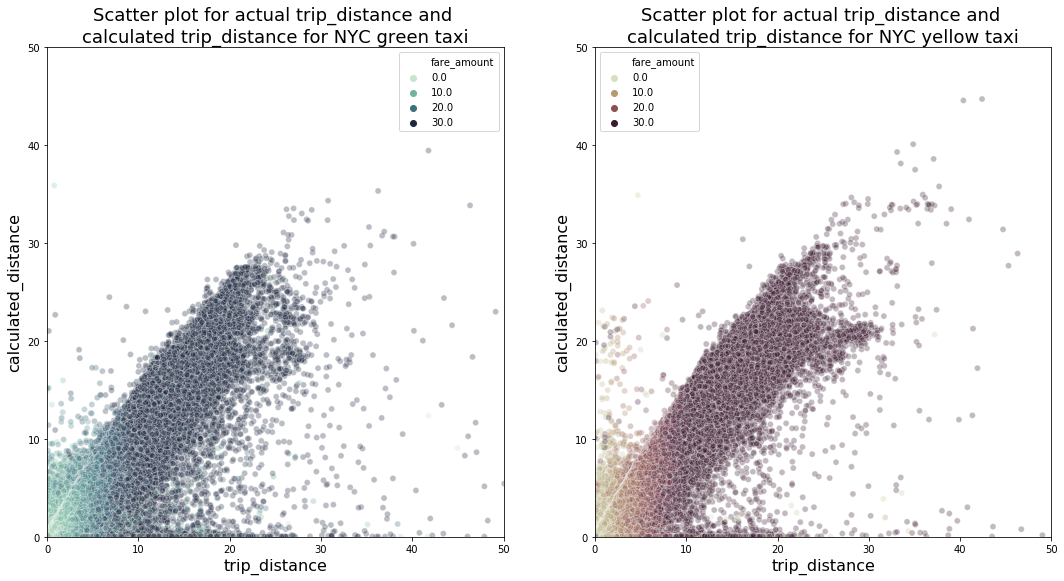

In [281]:
#sns.palplot(sns.cubehelix_palette(start = 2.8, rot=.1))
taxi = ['green', 'yellow']
cmap1 = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap2 = sns.cubehelix_palette(start = 0.36, rot=0.5, as_cmap=True)
cmap_list = [cmap1, cmap2]

taxi_green_df_g = taxi_green_df[(taxi_green_df.trip_distance <= 50) & (taxi_green_df.trip_duration <= 50)]
taxi_yellow_df_g = taxi_yellow_df[(taxi_yellow_df.trip_distance <= 50) & (taxi_yellow_df.trip_duration <= 50)]
df_list = [taxi_green_df, taxi_yellow_df]

fig, axs = plt.subplots(1,2, figsize = (18,9))
for i in np.arange(2):
    axs[i] = sns.scatterplot(x="trip_distance", y="distance_cal",hue="fare_amount", hue_norm= (0,30), data=df_list[i], palette=cmap_list[i], alpha = 0.3, ax = axs[i])
    axs[i].set_xlim((0,50))
    axs[i].set_ylim((0,50))
    axs[i].set_xlabel('trip_distance', fontsize=16)
    axs[i].set_ylabel('calculated_distance', fontsize=16)
    axs[i].set_title('Scatter plot for actual trip_distance and \ncalculated trip_distance for NYC {} taxi'.format(taxi[i]), fontsize=18)

In [285]:
cor_g = stats.pearsonr(taxi_green_df_g.trip_distance, taxi_green_df_g.distance_cal)
cor_y = stats.pearsonr(taxi_yellow_df_g.trip_distance, taxi_yellow_df_g.distance_cal)
print('Pearson correlation for actual and calculated trip distance for NYC green taxi data: {:.3f}'.format(cor_g[0]))
print('Pearson correlation for actual and calculated trip distance for NYC yellow taxi data: {:.3f}'.format(cor_y[0]))

Pearson correlation for actual and calculated trip distance for NYC green taxi data: 0.935
Pearson correlation for actual and calculated trip distance for NYC yellow taxi data: 0.966


As we can see from the plotted scatter plots as well as the calculated pearson correlation values, the calculated trip distance has a strong correlation with the actual trip distance though there are outliers that don't align along the y=x line. This suggests that given the pickup and dropoff coordinates of a trip, we can estimate the trip distance with some accuracy which is more applicable when we try to estimate the trip duration and trip fare amount based on the pickup and dropoff locations.

### 3.2.2 Trip distance versus trip duration

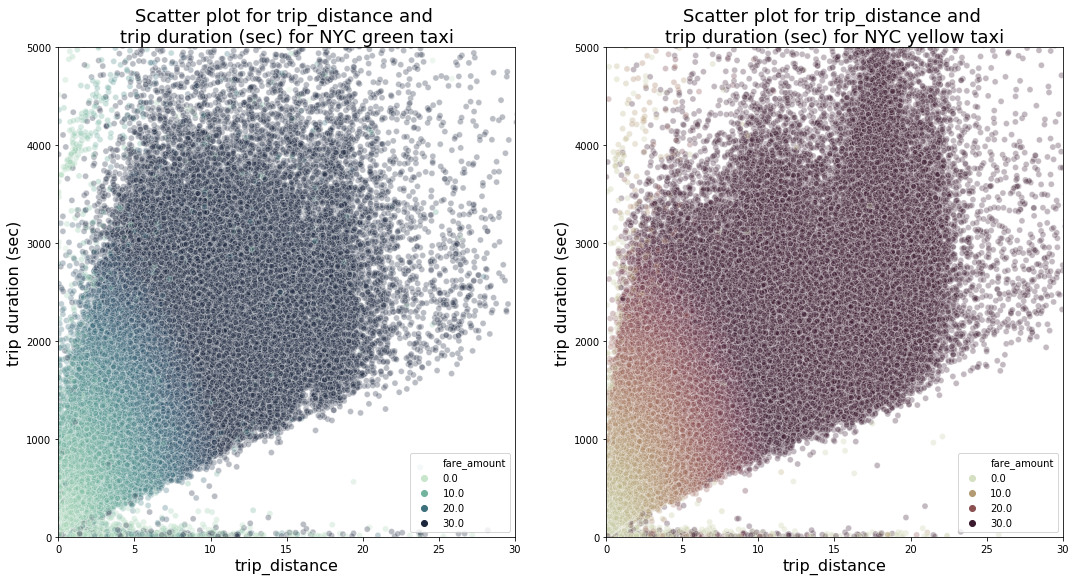

In [297]:
#sns.palplot(sns.cubehelix_palette(start = 2.8, rot=.1))
taxi = ['green', 'yellow']
cmap1 = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap2 = sns.cubehelix_palette(start = 0.36, rot=0.5, as_cmap=True)
cmap_list = [cmap1, cmap2]

taxi_green_df_g = taxi_green_df[(taxi_green_df.trip_distance <= 50) & (taxi_green_df.trip_duration_sec <= 5000)]
taxi_yellow_df_g = taxi_yellow_df[(taxi_yellow_df.trip_distance <= 50) & (taxi_yellow_df.trip_duration_sec <= 5000)]
df_list = [taxi_green_df, taxi_yellow_df]

fig, axs = plt.subplots(1,2, figsize = (18,9))
for i in np.arange(2):
    axs[i] = sns.scatterplot(x="trip_distance", y="trip_duration_sec",hue="fare_amount", hue_norm= (0,30), data=df_list[i], palette=cmap_list[i], alpha = 0.3, ax = axs[i])
    axs[i].set_xlim((0,30))
    axs[i].set_ylim((0,5000))
    axs[i].set_xlabel('trip_distance', fontsize=16)
    axs[i].set_ylabel('trip duration (sec)', fontsize=16)
    axs[i].set_title('Scatter plot for trip_distance and \ntrip duration (sec) for NYC {} taxi'.format(taxi[i]), fontsize=18)

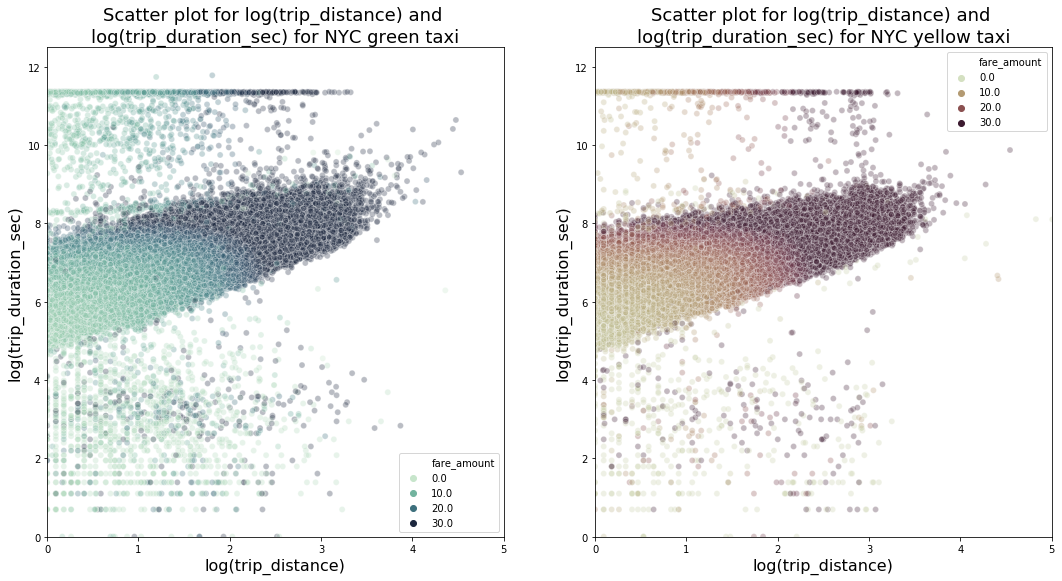

In [294]:
#sns.palplot(sns.cubehelix_palette(start = 2.8, rot=.1))
taxi = ['green', 'yellow']
cmap1 = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap2 = sns.cubehelix_palette(start = 0.36, rot=0.5, as_cmap=True)
cmap_list = [cmap1, cmap2]

taxi_green_df_g = taxi_green_df[(taxi_green_df.trip_distance <= 50) & (taxi_green_df.trip_duration_sec <= 5000)]
taxi_yellow_df_g = taxi_yellow_df[(taxi_yellow_df.trip_distance <= 50) & (taxi_yellow_df.trip_duration_sec <= 5000)]
df_list = [taxi_green_df, taxi_yellow_df]

fig, axs = plt.subplots(1,2, figsize = (18,9))
for i in np.arange(2):
    axs[i] = sns.scatterplot(x="trip_distance_log", y="trip_duration_sec_log",hue="fare_amount", hue_norm= (0,30), data=df_list[i], palette=cmap_list[i], alpha = 0.3, ax = axs[i])
    axs[i].set_xlim((0,5))
    axs[i].set_ylim((0,12.5))
    axs[i].set_xlabel('log(trip_distance)', fontsize=16)
    axs[i].set_ylabel('log(trip_duration_sec)', fontsize=16)
    axs[i].set_title('Scatter plot for log(trip_distance) and \nlog(trip_duration_sec) for NYC {} taxi'.format(taxi[i]), fontsize=18)

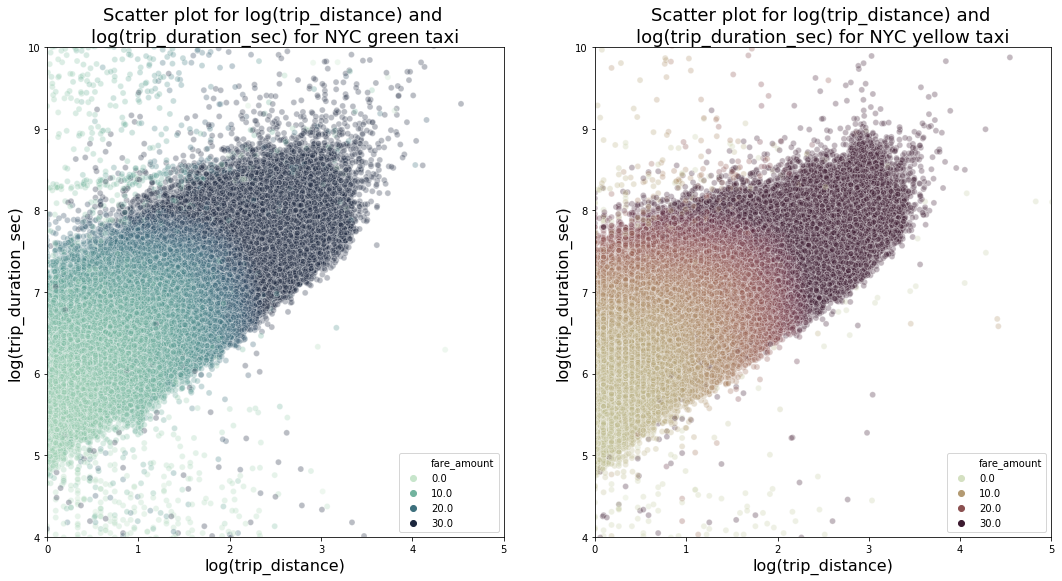

In [295]:
#sns.palplot(sns.cubehelix_palette(start = 2.8, rot=.1))
taxi = ['green', 'yellow']
cmap1 = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap2 = sns.cubehelix_palette(start = 0.36, rot=0.5, as_cmap=True)
cmap_list = [cmap1, cmap2]

taxi_green_df_g = taxi_green_df[(taxi_green_df.trip_distance <= 50) & (taxi_green_df.trip_duration_sec <= 5000)]
taxi_yellow_df_g = taxi_yellow_df[(taxi_yellow_df.trip_distance <= 50) & (taxi_yellow_df.trip_duration_sec <= 5000)]
df_list = [taxi_green_df, taxi_yellow_df]

fig, axs = plt.subplots(1,2, figsize = (18,9))
for i in np.arange(2):
    axs[i] = sns.scatterplot(x="trip_distance_log", y="trip_duration_sec_log",hue="fare_amount", hue_norm= (0,30), data=df_list[i], palette=cmap_list[i], alpha = 0.3, ax = axs[i])
    axs[i].set_xlim((0,5))
    axs[i].set_ylim((4,10))
    axs[i].set_xlabel('log(trip_distance)', fontsize=16)
    axs[i].set_ylabel('log(trip_duration_sec)', fontsize=16)
    axs[i].set_title('Scatter plot for log(trip_distance) and \nlog(trip_duration_sec) for NYC {} taxi'.format(taxi[i]), fontsize=18)

In [298]:
cor_g = stats.pearsonr(taxi_green_df_g.trip_distance, taxi_green_df_g.trip_duration_sec)
cor_y = stats.pearsonr(taxi_yellow_df_g.trip_distance, taxi_yellow_df_g.trip_duration_sec)
print('Pearson correlation for trip distance and trip duration for NYC green taxi data: {:.3f}'.format(cor_g[0]))
print('Pearson correlation for trip distance and trip duration for NYC yellow taxi data: {:.3f}'.format(cor_y[0]))

Pearson correlation for trip distance and trip duration for NYC green taxi data: 0.793
Pearson correlation for trip distance and trip duration for NYC yellow taxi data: 0.781


### 3.2.3 Trip distance versus trip fare

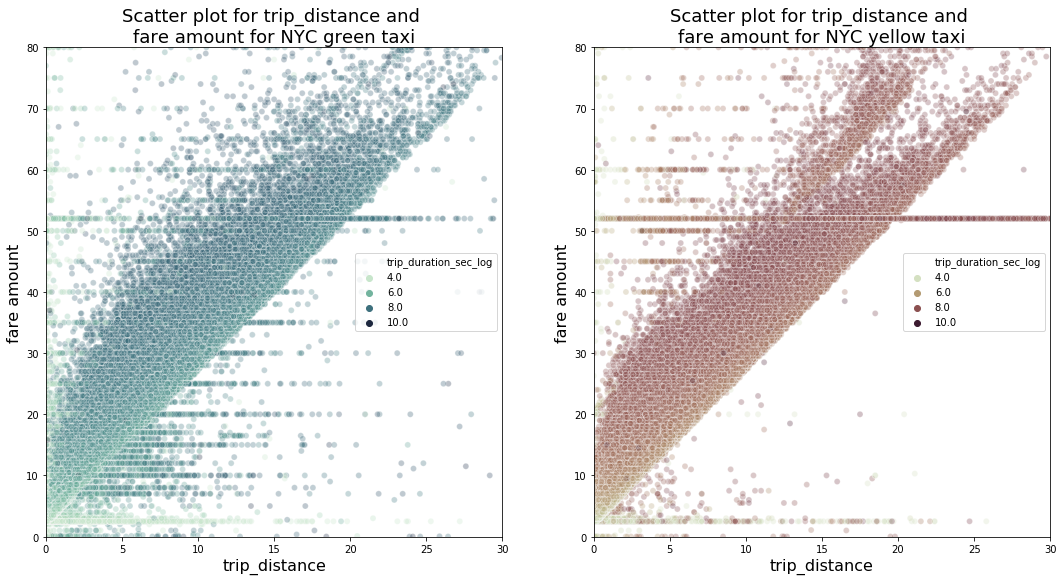

In [302]:
#sns.palplot(sns.cubehelix_palette(start = 2.8, rot=.1))
taxi = ['green', 'yellow']
cmap1 = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap2 = sns.cubehelix_palette(start = 0.36, rot=0.5, as_cmap=True)
cmap_list = [cmap1, cmap2]

taxi_green_df_g = taxi_green_df[(taxi_green_df.trip_distance <= 50) & (taxi_green_df.fare_amount <= 80)]
taxi_yellow_df_g = taxi_yellow_df[(taxi_yellow_df.trip_distance <= 50) & (taxi_yellow_df.fare_amount <= 80)]
df_list = [taxi_green_df, taxi_yellow_df]

fig, axs = plt.subplots(1,2, figsize = (18,9))
for i in np.arange(2):
    axs[i] = sns.scatterplot(x="trip_distance", y="fare_amount",hue="trip_duration_sec_log", hue_norm= (4,10), data=df_list[i], palette=cmap_list[i], alpha = 0.3, ax = axs[i])
    axs[i].set_xlim((0,30))
    axs[i].set_ylim((0,80))
    axs[i].set_xlabel('trip_distance', fontsize=16)
    axs[i].set_ylabel('fare amount', fontsize=16)
    axs[i].set_title('Scatter plot for trip_distance and \nfare amount for NYC {} taxi'.format(taxi[i]), fontsize=18)

In [303]:
cor_g = stats.pearsonr(taxi_green_df_g.trip_distance, taxi_green_df_g.fare_amount)
cor_y = stats.pearsonr(taxi_yellow_df_g.trip_distance, taxi_yellow_df_g.fare_amount)
print('Pearson correlation for trip distance and fare amount for NYC green taxi data: {:.3f}'.format(cor_g[0]))
print('Pearson correlation for trip distance and fare amount for NYC yellow taxi data: {:.3f}'.format(cor_y[0]))

Pearson correlation for trip distance and fare amount for NYC green taxi data: 0.940
Pearson correlation for trip distance and fare amount for NYC yellow taxi data: 0.954


Compared to trip duration, fare amount has a better correlation with trip distance. One possible explanation is that the trip duration can be affected by other external factors such as traffic, weather, etc. Although taxi fare is also composed of multiple components such as base fee, travel distance, waiting time (traffic), tolls and tips, the impact of travel distance outperforms the other factors and largely decide the fare amount.

reference: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

**Question**: What are the trips with a fare amount of $52?

In [365]:
taxi_green_farecount = taxi_green_df.fare_amount.value_counts().to_frame().reset_index().rename(columns={'index':'fare', 'fare_amount':'count'})
taxi_green_farecount[(taxi_green_farecount.fare >= 50) & (taxi_green_farecount.fare <= 54)].head()

fare  count
56  52.0   2493
86  50.0    442
97  50.5    239
98  51.0    220
99  51.5    219

In [366]:
taxi_yellow_farecount = taxi_yellow_df.fare_amount.value_counts().to_frame().reset_index().rename(columns={'index':'fare', 'fare_amount':'count'})
taxi_yellow_farecount[(taxi_yellow_farecount.fare >= 50) & (taxi_yellow_farecount.fare <= 54)].head()

fare  count
18   52.0  20496
91   50.0    321
98   51.0    188
99   51.5    178
100  50.5    177

In [341]:
taxi_green_df_52 = taxi_green_df[taxi_green_df.fare_amount == 52.00]
taxi_yellow_df_52 = taxi_yellow_df[taxi_yellow_df.fare_amount == 52.00]

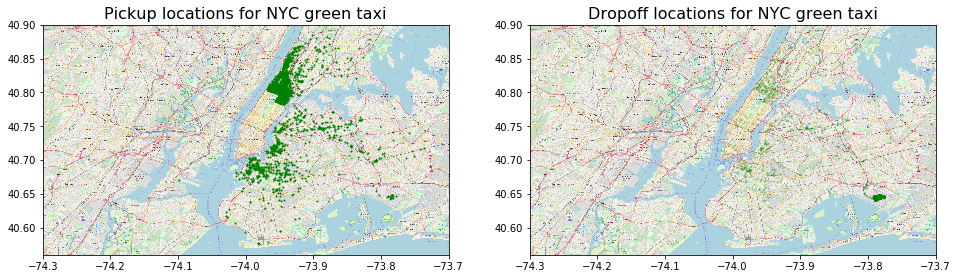

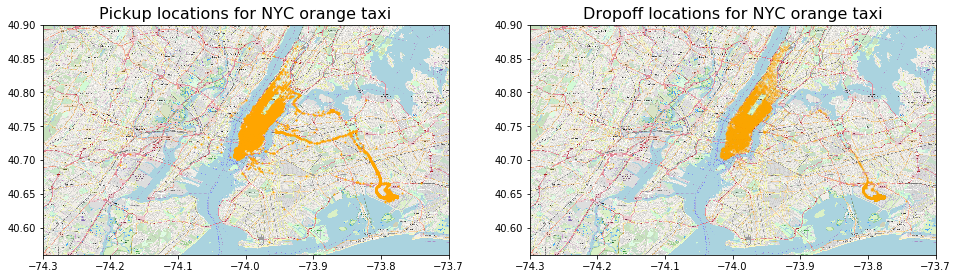

In [344]:
plot_traffic_map(taxi_green_df_52, LL, nyc_map, color = "green", alpha=1, size=1)
plot_traffic_map(taxi_yellow_df_52, LL, nyc_map, color = "orange", alpha=1, size=1)

**RateCodeID**
* 1= Standard rate
* 2=JFK
* 3=Newark
* 4=Nassau or Westchester
* 5=Negotiated fare
* 6=Group ride

In [361]:
taxi_green_df_52_JFK = taxi_green_df_52[taxi_green_df_52.RateCodeID == 2.0]
print('For {} trips by green taxi with a fare amoutn of $52.00:'.format(taxi_green_df_52.shape[0]))
print('    {} trips have pickup or dropoff locations in JFK'.format(taxi_green_df_52_JFK.shape[0]))
print('-'*30)
taxi_yellow_df_52_JFK = taxi_yellow_df_52[taxi_yellow_df_52.ratecodeID == 2.0]
print('For {} trips by yellow taxi with a fare amoutn of $52.00:'.format(taxi_yellow_df_52.shape[0]))
print('    {} trips have pickup or dropoff locations in JFK'.format(taxi_yellow_df_52_JFK.shape[0]))

For 2493 trips by green taxi with a fare amoutn of $52.00:
    2250 trips have pickup or dropoff locations in JFK
------------------------------
For 20496 trips by yellow taxi with a fare amoutn of $52.00:
    20284 trips have pickup or dropoff locations in JFK


In [364]:
taxi_green_df_52.RateCodeID.value_counts().to_frame().reset_index().rename(columns={'index':'ratecode_ID', 'RateCodeID':'count'})

ratecode_ID  count
0            2   2250
1            1    195
2            5     45
3            4      2
4            3      1

In [359]:
taxi_yellow_df_52.ratecodeID.value_counts().to_frame().reset_index().rename(columns={'index':'ratecode_ID', 'ratecodeID':'count'})

ratecode_ID  count
0          2.0  20284
1          1.0    176
2          5.0     32
3         99.0      2
4          3.0      1
5          4.0      1

Based on both the map plots and the ratecode_ID data, the trips with variable trip_distance but consistent fare_amount are trips with either pickup or dropoff locations at JFK.

In [367]:
# taxi_green_df.to_csv('summary/nyc_taxi_green_2015_combine_1000000_filter_log.csv', index = False)
# taxi_yellow_df.to_csv('summary/nyc_taxi_yellow_2015_combine_1000000_filter_log.csv', index = False)